In [1]:
# BATS load in processed data and begin mode projection 
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]
# ----------------------------------------------------------------------------------------------------------------------

In [2]:
rms_vort = 0.2 * f_ref  # defined for a specified vorticity rossby number 
eddy_turnaround = ((2*3.14)/(rms_vort))/(60*60*24)  # time in days for specified rms vorticity 
print(eddy_turnaround * 3)

14.2656560146


In [3]:
# --- LOAD in initial processing results
# these include, raw profiles, velocity profiles, displacement profiles, background density profiles...
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_initial_processing_2.pkl', 'rb')
IP = pickle.load(pkl_file)
pkl_file.close()
ref_lon = IP['ref_lon']
ref_lat = IP['ref_lat']
grid = IP['depth']
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
profile_tags = IP['raw_profile_tags']
sa = IP['sa']
ct = IP['ct']
gamma = IP['gamma']
prof_lon = IP['prof_lon']
prof_lat = IP['prof_lat']
prof_time = IP['profile_time']
bckgrds = IP['background_indices']
bckgrds_key = IP['background key']
bd1 = IP['bd1']
bd2 = IP['bd2']
lon_lim = IP['lon_lim']
lat_lim = IP['lat_lim']
dac_u = IP['dac_u']
dac_v = IP['dac_v']

N2 = IP['N2_by_season_quad']
sa_avg = IP['bckgrd_sa']
ct_avg = IP['bckgrd_ct']
theta_avg = IP['bckgrd_theta']
gamma_avg = IP['bckgrd_gamma']
mw_time = IP['mw_time']
mw_lon = IP['mw_lon']
mw_lat = IP['mw_lat']
mw_ct = IP['mw_ct']
mw_sa = IP['mw_sa']
mw_gamma = IP['mw_gamma']
mw_eta_1 = IP['eta_1']
mw_eta_2 = IP['eta_2']
mw_eta_3 = IP['eta_3']
eta_ind_1 = IP['eta_per_1']
eta_ind_3 = IP['eta_per_3']

mw_time_good = IP['mw_time_good']
gamma_good = IP['mw_gamma_good']
mw_eta_1_good = IP['eta_1_good']
mw_eta_2_good = IP['eta_2_good']
mw_eta_3_good = IP['eta_3_good']
mw_v_good = IP['dg_v_good']
mw_v_e_good = IP['dg_v_e_good']
mw_v_n_good = IP['dg_v_n_good']
mw_prof_good = IP['mw_prof_good']
PE_per_prof = IP['PE_per_prof']
PE_per_prof_time = IP['PE_per_prof_time']
PE_per_prof_tag = IP['PE_per_prof_tag']

dg_fol_sla = IP['glider_following_sla']
dg_den_grid = IP['dg_den_grid']
dg_den_deps = IP['dg_den_deps']

t_s = datetime.date.fromordinal(np.int(np.nanmin(prof_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(prof_time)))

In [4]:
np.shape(sa[-20, :])
# print(bd1)
# print(bd2)

(328,)

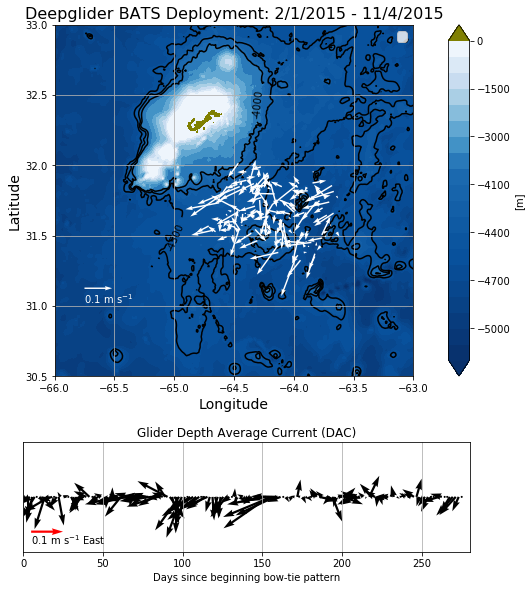

In [10]:
# PLAN VIEW PLOt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

bath = '/Users/jake/Desktop/bats/bats_bathymetry/GEBCO_2014_2D_-67.7_29.8_-59.9_34.8.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid.variables['lon'][:]
bath_lat = bath_fid.variables['lat'][:]
bath_z = bath_fid.variables['elevation'][:]
levels = [-5200, -5100, -5000, -4900, -4800, -4700, -4600,
          -4500, -4400, -4300, -4200, -4100, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0]

matplotlib.rcParams['figure.figsize'] = (8,13)
# fig0, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig0 = plt.figure(figsize=(8, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

cmap = plt.cm.get_cmap("Blues_r")
cmap.set_over('#808000')  # ('#E6E6E6')
bc = ax0.contourf(bath_lon, bath_lat, bath_z, levels, cmap='Blues_r', extend='both', zorder=0)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
bcl = ax0.contour(bath_lon, bath_lat, bath_z, [-4500, -4250, -4000], colors='k', zorder=0)
ml = [(-65, 31.5), (-64.4, 32.435)]
ax0.clabel(bcl, manual=ml, inline_spacing=-3, fmt='%1.0f', colors='k')

# ax0.scatter(mw_lon, mw_lat, s=3, color='#DAA520')
# ax0.plot(mw_lon, mw_lat, color='#DAA520',
#         label='Dive-cyle No. (' + str(int(profile_tags[0])) + '-' + str(int(profile_tags[-2])) + ')', zorder=1)

# ax0.plot([-64.8, -63.59], [31.2, 31.2], color='w', zorder=2)
# ax0.text(-64.3, 31.1, '115km', color='w', fontsize=14, fontweight='bold')
# ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=3)
# ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=4)
# ax0.text(-(64 + (10 / 60)) + .05, 31 + (40 / 60) - .07, 'Sta. BATS', color='w', fontsize=14, fontweight='bold')

tdu = np.nan * np.ones(164)
tdv = np.nan * np.ones(164)
tlon = np.nan * np.ones(164)
tlat = np.nan * np.ones(164)
tt = np.nan * np.ones(164)
count = 0
for i in range(0, 328, 2):
    tdu[count] = dac_u[i]
    tdv[count] = dac_v[i]
    tlon[count] = np.nanmean(prof_lon[:, i:i+2])
    tlat[count] = np.nanmean(prof_lat[:, i:i+2])
    tt[count] = np.nanmean(prof_time[i:i+2])
    count = count + 1

ax0.quiver(tlon, tlat, tdu, tdv, color='w', scale=1.3, width=0.004, zorder=2)
ax0.quiver(-65.75, 31.125, 0.1, 0, color='w', scale=1.3, width=0.004, zorder=2)
ax0.text(-65.75, 31.02, r'0.1 m s$^{-1}$', color='w' )

w = 1 / np.cos(np.deg2rad(ref_lat))
ax0.set_aspect(w)
ax0.set_xlim([-66, -63])
ax0.set_ylim([30.5, 33])
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig0.colorbar(bc, cax=cax, label='[m]')
ax0.set_xlabel('Longitude', fontsize=14)
ax0.set_ylabel('Latitude', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=13)
ax0.set_title('Deepglider BATS Deployment: ' + np.str(t_s.month) + '/' + np.str(t_s.day) + '/' + np.str(
    t_s.year) + ' - ' + np.str(t_e.month) + '/' + np.str(t_e.day) + '/' + np.str(t_e.year), fontsize=16)
# plt.tight_layout()
ax0.grid()

ax1.quiver(tt - np.nanmin(tt), np.zeros(len(tdu)), tdu, tdv, scale=1.4, width=0.005) 
ax1.set_xlim([0, 280])
ax1.set_xlabel('Days since beginning bow-tie pattern')
ax1.set_title('Glider Depth Average Current (DAC)')
ax1.quiver(5, -.19, 0.1, 0, color='r', scale=1.4, width=0.005, zorder=2)
ax1.text(5, -.26, r'0.1 m s$^{-1}$ East', color='k' )
ax1.set_ylim([-.3, .3])
ax1.axes.get_yaxis().set_ticks([])
plot_pro(ax1)
fig0.savefig("/Users/jake/Documents/Conferences/ocean_sciences/2020/sample_plan_w_dac.jpg", dpi=400)

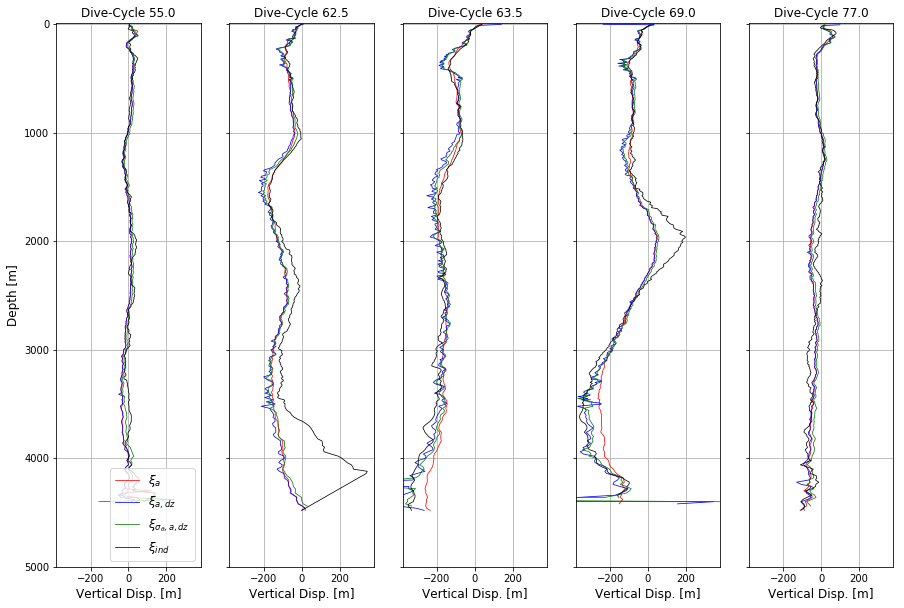

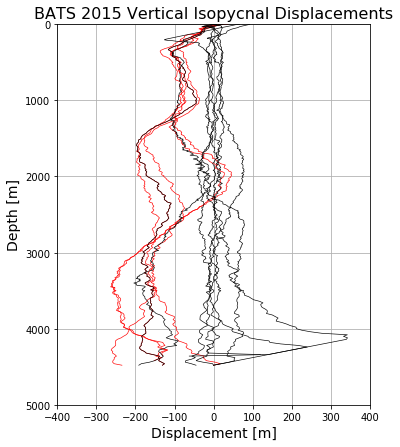

()

In [5]:
# plot etas calculated above
# these_profiles = np.array([27.5,   28. ,   28.5,   40.5,   48.5])
# these_profiles = np.array([52, 53, 54, 55, 56])
# these_profiles = np.array([75.5, 76, 76.5, 77, 77.5])
# these_profiles = np.array([ 81.5,   82. ,   82.5,   83. ,   83.5])
# these_profiles = np.array([132.5,  133. ,  133.5,  134. ,  134.5,])
# these_profiles = np.array([50, 75, 100, 125])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([60, 85, 110, 135])  # dive numbers of profiles to compare (individual dives)
these_profiles = np.array([55, 62.5, 63.5, 69, 77])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([67, 68, 69, 70, 71])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([72, 72.5, 73, 73.5, 74])  # dive numbers of profiles to compare (individual dives)

plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    avg_rel = mw_prof_good == these_profiles[i]
    ax[i].plot(mw_eta_3_good[:, avg_rel], grid, color='r', linewidth=0.75, label=r'$\xi_a$')  # avg direct search, gamma
    ax[i].plot(-1 * mw_eta_1_good[:, avg_rel], grid, color='b', linewidth=0.75, label=r'$\xi_{a,dz}$')  # avg divide by ddz, gamma
    ax[i].plot(-1 * mw_eta_2_good[:, avg_rel], grid, color='g', linewidth=0.75, label=r'$\xi_{\sigma_{\theta},a,dz}$')  # avg divide by ddz, pot den, local pref
    ax[i].plot(eta_ind_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\xi_{ind}$')  # individual profiles direct search, gamma    
    ax[i].set_xlim([-380, 380])
    ax[i].set_title('Dive-Cycle ' + str(these_profiles[i]))
    ax[i].set_xlabel('Vertical Disp. [m]', fontsize=12)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=12, loc=4)
ax[0].set_ylabel('Depth [m]', fontsize=12)
ax[0].set_ylim([-10, 5000])
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])
# ax[4].grid()
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_15_eddy_etas.jpg", dpi=300)

matplotlib.rcParams['figure.figsize'] = (5.6, 7)
f, ax = plt.subplots()
these_profiles = [62.5, 63, 63.5, 68.5, 69]
for i in range(len(these_profiles)):
    avg_rel = mw_prof_good == these_profiles[i]
    ax.plot(mw_eta_3_good[:, avg_rel], grid, linewidth=0.65, color='r')
for i in [5, 25, 30, 80, 90, 100, 110, 115]:    
    ax.plot(mw_eta_3_good[:, i], grid, linewidth=0.65, color='k')
ax.set_ylim([0, 5000])   
ax.set_xlim([-400, 400])
ax.set_xlabel('Displacement [m]', fontsize=14)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_title('BATS 2015 Vertical Isopycnal Displacements', fontsize=16)
ax.invert_yaxis()
plot_pro(ax)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats15_disps.jpg", dpi=300)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


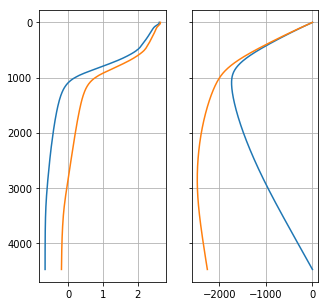

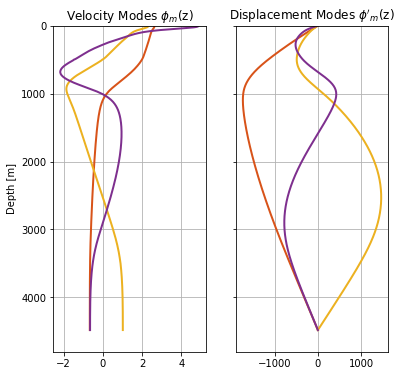

()

In [6]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# -- (if we choose 3 seasons) 
# bckgrds_info = ['Win_1', 'Win_2', 'Win_3', 'Win_4', 'Sum_1', 'Sum_2', 'Sum_3', 'Sum_4',
#                 'Fall_1', 'Fall_2', 'Fall_3', 'Fall_4']
# G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2[:, 0:4], axis=1), grid, omega, mmax)  # winter
# G_1, Gz_1, c_1, epsilon_1 = vertical_modes(np.nanmean(N2[:, 4:8], axis=1), grid, omega, mmax)  # summer
# G_2, Gz_2, c_2, epsilon_2 = vertical_modes(np.nanmean(N2[:, 8:], axis=1), grid, omega, mmax)  # fall
# -- (with 2 seasons) 
# bckgrds_info = ['Win_1', 'Win_2', 'Win_3', 'Win_4', 'Sum_1', 'Sum_2', 'Sum_3', 'Sum_4']
G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2[:, 0:4], axis=1), grid, omega, mmax)
G_1, Gz_1, c_1, epsilon_1 = vertical_modes(np.nanmean(N2[:, 4:], axis=1), grid, omega, mmax)
Gs = [G_0, G_1]
Gzs = [Gz_0, Gz_1]
cs = [c_0, c_1]
epsilons = [epsilon_0, epsilon_1]
# test using average over entire year
N2_tot = np.nanmean(N2, axis=1)
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(N2_tot, grid, omega, mmax)  # N2

# --- compute alternate vertical modes (allowing for a sloping bottom)
bc_bot = 1  # 1 = flat, 2 = rough
slope = 3.0*10**(-3)  # 5.0*10**(-2)
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, np.nanmean(N2, axis=1))
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot, ref_lat, slope)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

plt.rcParams['figure.figsize'] = 5, 5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(Gz_tot[:, 1], grid)
ax1.plot(F[:, 1], grid)
ax2.plot(G_tot[:, 1], grid)
ax2.plot(F_int[:, 1], grid)
# ax1.set_ylim([900, 3500])
ax1.grid()
ax1.invert_yaxis()
plot_pro(ax2)

mode_colors = ['#0072BD', '#D85319', '#ECB120', '#7E2F8E']
plt.rcParams['figure.figsize'] = 6, 6
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(Gz_tot[:, 1], grid, color=mode_colors[1], linewidth=2)
ax1.plot(Gz_tot[:, 2], grid, color=mode_colors[2], linewidth=2)
ax1.plot(Gz_tot[:, 3], grid, color=mode_colors[3], linewidth=2)
# ax1.plot(F[:, 1], grid)
ax1.set_title(r'Velocity Modes $\phi_m$(z)')
ax1.set_ylabel('Depth [m]')
ax2.plot(G_tot[:, 1], grid, color=mode_colors[1], linewidth=2)
ax2.plot(G_tot[:, 2], grid, color=mode_colors[2], linewidth=2)
ax2.plot(G_tot[:, 3], grid, color=mode_colors[3], linewidth=2)
# ax2.plot(F_int[:, 1], grid)
ax2.set_title(r"Displacement Modes $\phi'_m$(z)")
ax1.set_ylim([0, 4800])
ax1.grid()
ax1.invert_yaxis()
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/normal_fb_modes.jpg", dpi=300)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice


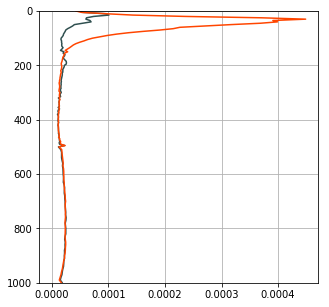

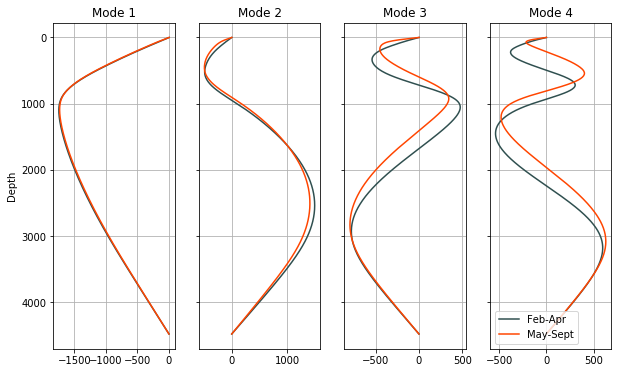

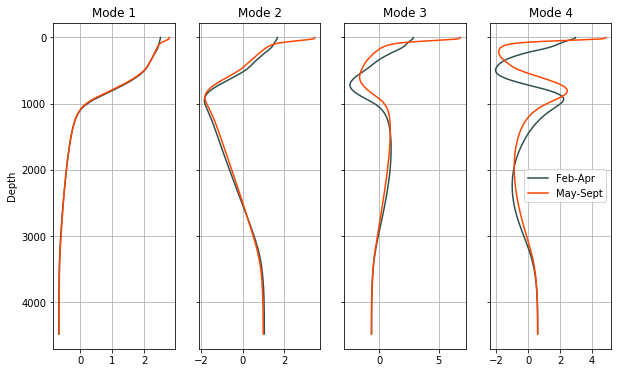

()

In [9]:
# PLOT --- test season differences in modes
plt.rcParams['figure.figsize'] = 5, 5
f, ax = plt.subplots()
ax.plot(np.nanmean(N2[:, 0:4], axis=1), grid, color=cols[0])
ax.plot(np.nanmean(N2[:, 4:8], axis=1), grid, color=cols[1])
ax.plot(np.nanmean(N2[:, 8:], axis=1), grid, color=cols[2])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
plot_pro(ax)

plt.rcParams['figure.figsize'] = 10, 6
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gzs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gzs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gzs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gzs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)

From Zhao et al. 2016 (appendix A), the ratio of surface displacement to maximum interior displacement. He gave me a map at BATS of the surface displacement from the M2 and S2 internal tides (order 1 - 5mm). For every 1mm surface displacement we expect 750mm maximum interior displacement (for mode 1). If I estimate the interior displacement using his estimate of surface amplitude and my mode shapes (where there is a free surface, skewing his estimate) I get an interior displacement of less than 10 m for both the M2 and S2 tides.

In [7]:
# testing of tides from Dr. Zhao
normalizer = (1/np.nanmax(grid))*np.trapz(Gzs[0][:, 1]**2, grid)
(0.005) / ((1/g) * np.trapz(Gzs[0][:, 1] * np.nanmean(N2[:, 2:4], axis=1), grid))

# Kjellsson and Zanna paper 2017 on the importance of resolving the deformation radius in modes 
Lr1 = (1/3.14159) * np.trapz(np.sqrt(N2[:, 0])/f_ref, grid)
print(Lr1/1000)
print((cs[0][1:4]/f_ref)/1000)

# from the zanna paper Lr = radius of deformation (in figure 5, plot wavenumber )
1. / ((1.7 * 10**(-4))/(2*3.14))

34.7815765833
[ 39.41100378  16.40427487  11.82288771]


36941.17647058823

In [8]:
# --- SPLIT INTO 3 SEASONS (ignore quadrants, differences in mode shapres have little effect)
# d2_winter = np.where((mw_time_good < bd1) & ((mw_prof_good < 60) | (mw_prof_good > 71)))[0]
# d2_summer = np.where((mw_time_good > bd1) & (mw_time_good < bd2))[0] 
# d2_fall = np.where(mw_time_good > bd2)[0]
# bckgrds2 = [d2_winter, d2_summer, d2_fall] 
d2_winter = np.where((mw_time_good < bd1) & ((mw_prof_good < 60) | (mw_prof_good > 71)))[0]
d2_summer = np.where((mw_time_good > bd1) & ((mw_prof_good < 60) | (mw_prof_good > 71)))[0]

In [9]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(mw_eta_3_good)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AG_ind = np.zeros([nmodes, np.shape(eta_ind_3)[1]])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
Eta_ind_m = np.zeros([np.size(grid), np.shape(eta_ind_3)[1]])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
PE_ind_per_mass = np.zeros([nmodes, np.shape(eta_ind_3)[1]])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    if len(np.intersect1d(d2_winter, i)) | ((mw_prof_good[i] > 60) & (mw_prof_good[i] < 71)):
        G = G_0
        Gz = Gz_0
        c = c_0
        this_N2 = np.nanmean(N2[:, 0:4], axis=1)
    # elif len(np.intersect1d(d2_summer, i)):
    #     G = G_1
    #     Gz = Gz_1
    #     c = c_1
    #     this_N2 = np.nanmean(N2[:, 4:8], axis=1)
    else:
        G = G_1
        Gz = Gz_1
        c = c_1
        this_N2 = np.nanmean(N2[:, 4:], axis=1)

    # fit to velocity profiles
    this_V = mw_v_good[:, i].copy() # SELECT V HERE 
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        # HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        HKE_per_mass[:, i] = (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = mw_eta_3_good[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    Neta[:, i] = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy

# --- eta individual 
for i in range(len(eta_ind_3[1, :])): 
    # fit to individual eta profiles
    this_eta = eta_ind_3[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    # Neta = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG_ind[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_ind_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG_ind[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG_ind[:, i]))))
        PE_ind_per_mass[:, i] = (1 / 2) * AG_ind[:, i] * AG_ind[:, i] * c * c

        np.where(PE_ind_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_ind_per_mass[modest, i] >= PE_noise_threshold)
        # if np.size(iwal) > 0:
        #     good_pe_prof[i] = 0  # flag profile as noisy            
            
# end loop over each v and eta for fitting

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in greater_equal
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in greater_equal
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:117: RuntimeWarning: invalid value encountered in greater_equal
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:118: RuntimeWarning: invalid value encountered in greater_equal


In [10]:
# --- check on mode amplitudes from averaging or individual profiles
mw_time_ordered_i = np.argsort(mw_time_good)
mw_v_ordered = mw_v_good[:, mw_time_ordered_i]
mw_lon_ordered = mw_lon[mw_time_ordered_i]
mw_lat_ordered = mw_lat[mw_time_ordered_i]
AG_ordered = AG[:, mw_time_ordered_i]
AGz_ordered = AGz[:, mw_time_ordered_i]
Time_ordered = mw_time_good[mw_time_ordered_i]
HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
Info3 = mw_prof_good[mw_time_ordered_i]
V_ordered = mw_v_good[:, mw_time_ordered_i]
Vm_ordered = V_m[:, mw_time_ordered_i]
Eta_ordered = mw_eta_3_good[:, mw_time_ordered_i]  #SELECT ETA AGAIN HERE 
Etam_ordered = Eta_m[:, mw_time_ordered_i]

In [146]:
# EOF svd 
grid_sub_i_2 = range(10, 415)
grid_sub_i_3 = range(10, 440)

import scipy
# --- eta 
gg = []
for i in range(np.shape(Eta_ordered)[1]):
    if np.nansum(np.isnan(Eta_ordered[10:-25, i])) == 0:
        gg.append(True)
    else:
        gg.append(False)        
eta_eof_time = Time_ordered[gg]
        
etazq = Eta_ordered[:, gg]  
etazq = etazq[grid_sub_i_2, :]
nq = np.size(etazq[0, :])
avg_etazq = np.nanmean(np.transpose(etazq), axis=0)
data_eta = etazq # - np.transpose(np.tile(avg_etazq, [nq, 1]))
[UUe, SSe, VVe] = scipy.linalg.svd(data_eta) # , full_matrices=False, compute_uv=True)

p = np.min([np.shape(data_eta)[0], np.shape(data_eta)[1]])
Spe=SSe[0:p];
lambe=np.matrix(Spe[:, None])*np.transpose(np.matrix(Spe[:, None]));
var_eta=np.trace(lambe);
frac_eof_eta=np.diag(lambe)/var_eta;

# --- glider u, v    
# orient such that all are the same sign 
V_ordered_abs = V_ordered.copy()
for i in range(np.shape(V_ordered)[1]):
    if np.nanmean(V_ordered[0:300, i]) < 0:
        V_ordered_abs[:, i] = -1.0 * V_ordered[:, i]
gg = []
for i in range(np.shape(V_ordered_abs)[1]):
    if np.nansum(np.isnan(V_ordered_abs[10:-10, i])) == 0:
        gg.append(True)
        if np.nanmean(np.abs(V_ordered_abs[440:, i])) > 0.15:
            gg[i] = False
    else:
        gg.append(False)   

# uv_in = np.concatenate((np.arange(0, 50), np.arange(70, 131)))
mw_v_ordered_sub = V_ordered_abs[:, gg].copy()
UVzq = mw_v_ordered_sub[grid_sub_i_3, :]
nq_uv = np.size(UVzq[0, :])
avg_UVzq = np.nanmean(np.transpose(UVzq), axis=0)
data_UV = UVzq - np.transpose(np.tile(avg_UVzq, [nq_uv, 1]))
[UU3, SS3, VV3] = scipy.linalg.svd(data_UV, full_matrices=False, compute_uv=True)

p3 = np.min([np.shape(data_UV)[0], np.shape(data_UV)[1]])
Sp3=SS3[0:p3];
lamb3=np.matrix(Sp3[:, None])*np.transpose(np.matrix(Sp3[:, None]));
var_uv=np.trace(lamb3);
frac_eof_uv=np.diag(lamb3)/var_uv;

Amp1_uv = VV3[0, :]*SS3[0]
Amp2_uv = VV3[1, :]*SS3[1]
Amp1_eta = VVe[0, :]*SSe[0]
print('number of used velocity profiles = ', str(np.nansum(gg)))

number of used velocity profiles =  120


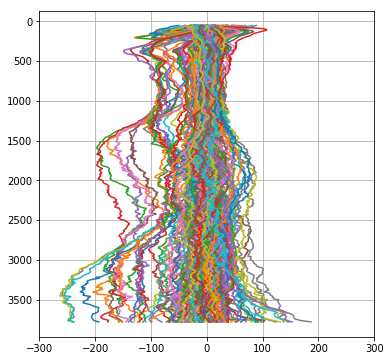

()

In [13]:
f, ax = plt.subplots()
for i in range(np.shape(data_eta)[1]):
    ax.plot(data_eta[:, i], grid[grid_sub_i_2])
    if np.sum(np.isnan(data_eta[:, i])) > 0:
        print(i)
        print(np.where(np.isnan(data_eta[:, i])))
ax.set_xlim([-300, 300])
ax.invert_yaxis()    
plot_pro(ax)

In [72]:
np.where(np.isnan(V_ordered[430, :]))[0]

array([55])

In [137]:
# --- EOF of velocity profiles (for whole mission) (ORIGINAL EIGENVALUE SOLUTION TECHNIQUE)
grid_reg = np.arange(0, np.nanmax(grid), 10)
v_reg = np.nan * np.ones((len(grid_reg), np.shape(mw_v_good)[1]))
eta_reg_0 = np.nan * np.ones((len(grid_reg), np.shape(Eta_ordered)[1]))
for i in range(np.shape(mw_v_good)[1]):
    v_reg[:, i] = np.interp(grid_reg, grid, mw_v_good[:, i])
    eta_reg_0[:, i] = np.interp(grid_reg, grid, Eta_ordered[:, i])
n2_reg = np.interp(grid_reg, grid, N2_tot)  
grid_sub_i = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
              110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 
              210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 
              310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 
              410, 420]

check1 = 7      # upper index to include in eof computation
check2 = -10     # lower index to include in eof computation
grid_check = grid_reg[grid_sub_i]

# orient such that all are the same sign 
V_ordered_abs = V_ordered.copy()
for i in range(np.shape(V_ordered)[1]):
    if np.nanmean(V_ordered[0:300, i]) < 0:
        V_ordered_abs[:, i] = -1.0 * V_ordered[:, i]

gg = []
for i in range(np.shape(V_ordered_abs)[1]):
    if np.nansum(np.isnan(V_ordered_abs[10:-10, i])) == 0:
        gg.append(True)
        if np.nanmean(np.abs(V_ordered_abs[440:, i])) > 0.15:
            gg[i] = False
    else:
        gg.append(False) 
        
grid_sub_i_3 = range(10, 440)
mw_v_ordered_sub = V_ordered_abs[:, gg].copy()  # remove profiles with high velocities at 4000 m
UVzq = mw_v_ordered_sub[grid_sub_i_3, :]  # alter z_grid indices to remove nans 
V4 = UVzq.copy()

Uzq = V4
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))  # velocity anomaly matrix
# Uzqa = Uzqa_0*(np.transpose(np.tile(weights, [nq, 1])))  # multiply by weights 
cov_Uzqa = (1. / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
t1 = np.real(D_Uzqa[0:15])
PEV = t1 / np.sum(t1)

# displacement EOFS
# good = np.where(~np.isnan(eta_reg_0[400, :]))[0]
# check1 = 10      # upper index to include in eof computation
# check2 = -40     # lower index to include in eof computation
# grid_check_e = grid_reg[check1:check2]
# weights = (10**(1/2))*np.sqrt(n2_reg[check1:check2])
# eta_reg_1 = eta_reg_0[check1:check2, good].copy()
# nq = np.size(eta_reg_1[0, :])
# eta_reg = eta_reg_1*(np.transpose(np.tile(weights, [nq, 1])))  # multiply by weights 
# cov_eta_qa = (1. / nq) * np.matrix(eta_reg) * np.matrix(np.transpose(eta_reg))
# D_eta_qa, V_eta_qa = np.linalg.eig(cov_eta_qa)
# t1 = np.real(D_eta_qa[0:15])
# PEV_eta = t1 / np.sum(t1)

In [136]:
np.shape(Uzq)
np.where(np.abs(V_ordered_abs[440, :]) > 0.15)[0]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


array([ 79,  81, 126, 127])

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


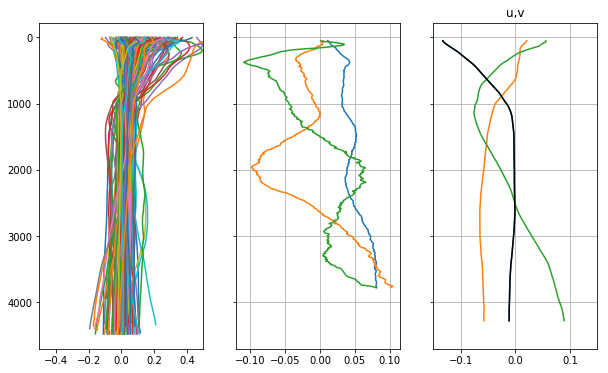

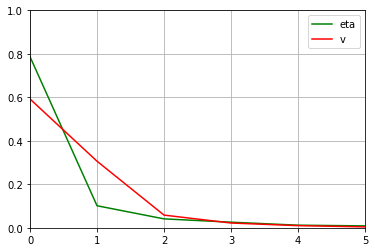

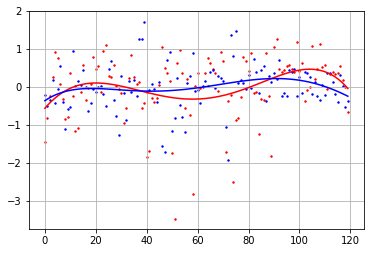

()

In [147]:
matplotlib.rcParams['figure.figsize'] = (10, 6)
f, (ax00, ax0, ax3) = plt.subplots(1, 3, sharey=True)
        
for i in range(np.shape(V_ordered)[1]):
    ax00.plot(V_ordered_abs[:, i], grid)
ax00.set_xlim([-.5, .5])
   
ax0.plot(UUe[:, 0], grid[grid_sub_i_2])
ax0.plot(UUe[:, 1], grid[grid_sub_i_2])
ax0.plot(UUe[:, 2], grid[grid_sub_i_2])
ax0.grid()
ax0.invert_yaxis()
ax3.plot(UU3[:, 0], grid[grid_sub_i_3])
ax3.plot(UU3[:, 1], grid[grid_sub_i_3])
ax3.plot(UU3[:, 2], grid[grid_sub_i_3])
ax3.plot(1.0*V_Uzqa[:, 0], grid[grid_sub_i_3], 'k')
ax3.set_title('u,v')
ax3.set_xlim([-.15, .15])
plot_pro(ax3)

matplotlib.rcParams['figure.figsize'] = (6, 4)
f, ax = plt.subplots()
ax.plot(np.arange(0, len(frac_eof_eta)), frac_eof_eta, color='g', label='eta')
ax.plot(np.arange(0, len(frac_eof_uv)), frac_eof_uv, color='r', label='v')
ax.set_ylim([0, 1])
ax.set_xlim([0, 5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
plot_pro(ax)

f, ax = plt.subplots()
p1 = np.polyfit(np.arange(0, nq_uv), Amp1_uv, 5)
p2 = np.polyfit(np.arange(0, nq_uv), Amp2_uv, 5)
ax.scatter(np.arange(0, nq_uv), Amp1_uv, color='r', s=2)
ax.plot(np.arange(0, nq_uv), np.polyval(p1, np.arange(0, nq_uv)), color='r')
ax.scatter(np.arange(0, nq_uv), Amp2_uv, color='b', s=2)
ax.plot(np.arange(0, nq_uv), np.polyval(p2, np.arange(0, nq_uv)), color='b')
plot_pro(ax)

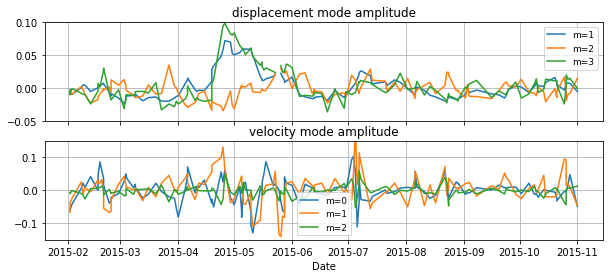

()

In [16]:
# mode amplitudes in time 
# are displacement and velocity modes correlated? 
this_timer = mw_time_good[mw_time_ordered_i]
this_timer_date = []
for i in range(len(this_timer)):
    this_timer_date.append(datetime.date.fromordinal(np.int(this_timer[i])))

matplotlib.rcParams['figure.figsize'] = (10, 4)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(this_timer_date, AG_ordered[1, :], label='m=1')
ax1.plot(this_timer_date, AG_ordered[2, :], label='m=2')
ax1.plot(this_timer_date, AG_ordered[3, :], label='m=3')
ax1.set_title('displacement mode amplitude')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=9)
ax1.grid()
ax1.set_ylim([-0.05, 0.1])
# mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i])
ax2.plot(this_timer_date, AGz_ordered[0, :], label='m=0')
ax2.plot(this_timer_date, AGz_ordered[1, :], label='m=1')
ax2.plot(this_timer_date, AGz_ordered[2, :], label='m=2')
ax2.set_title('velocity mode amplitude')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=9)
ax2.set_xlabel('Date')
ax2.set_ylim([-.15, .15])
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_15_mode_amps.jpg", dpi=300)

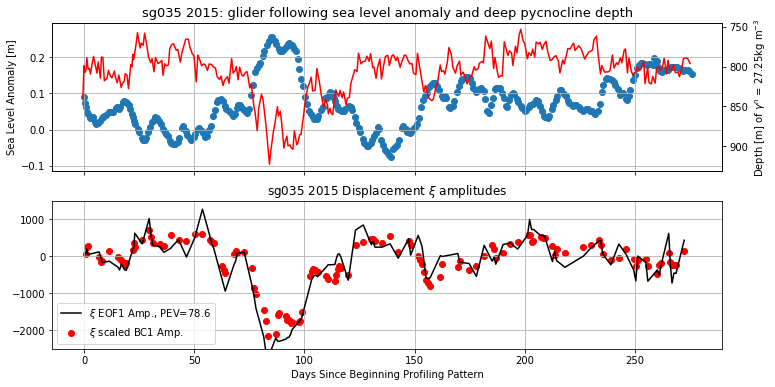

()

In [17]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
f, (ax00, ax0) = plt.subplots(2, 1, sharex=True)
ax00.scatter(prof_time - np.nanmin(prof_time), dg_fol_sla)
ax00.set_ylabel('Sea Level Anomaly [m]')
ax00.set_title('sg035 2015: glider following sea level anomaly and deep pycnocline depth', fontsize=13)
ax01 = ax00.twinx()
ax01.plot(prof_time - np.nanmin(mw_time_good), dg_den_deps[25, :], color='r')
ax01.invert_yaxis()
ax01.set_ylabel('Depth [m] of $\gamma^{n}$ = ' + str(dg_den_grid[0][25]) + 'kg m$^{-3}$')
ax00.grid()

ax0.plot(eta_eof_time - np.nanmin(prof_time), Amp1_eta, color='k', label=r'$\xi$ EOF1 Amp., PEV=' + str(np.round(frac_eof_eta[0]*100,1)))
ax0.scatter(Time_ordered - np.nanmin(prof_time), -30000*AG_ordered[1, :], color='r', label=r'$\xi$ scaled BC1 Amp.')
# this_timer_date_2 = this_timer_date[0:-1]
# for i in range(len(this_timer_date)):
#     if (i < 55) & (i > 55):
#         this_timer_date_2[i] = this_timer_date[i]
# ax1.plot(this_timer_date_2, Amp1_uv, color='k', label='vel. EOF1 Amp., PEV=' + str(np.round(frac_eof_uv[0]*100,1)))
# ax1.scatter(this_timer_date, -8*(AGz_ordered[1, :] + AGz_ordered[1, :]), color='r', label='vel. scaled BT + BC1 Amp.')
ax0.set_ylim([-2500, 1500])
ax0.set_title(r'sg035 2015 Displacement $\xi$ amplitudes')
ax0.set_xlabel('Days Since Beginning Profiling Pattern')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)
plot_pro(ax0)

# ax1.set_ylim([-3, 5])
# ax1.set_title('sg035 2015 Velocity amplitudes')
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels, fontsize=10)
# plot_pro(ax1)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_eta_eof_mode_amps.jpg", dpi=300)

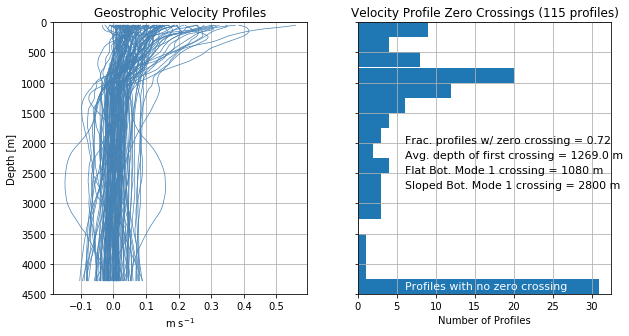

% profiles w/ zero crossing = 0.7217391304347827
Avg. depth of crossing = 1268.6746988
% of profiles with negative bottom velocity = 0.504347826087


In [25]:
# look at zero crossings 
V5 = V4.copy()
grid_reg = grid[grid_sub_i_3]

# orient such that all are the same sign 
plt.rcParams['figure.figsize'] = 10, 5
f, (ax0, ax) = plt.subplots(1, 2, sharey=True)
for i in range(np.shape(V5)[1]):
    up_avg = np.nanmean(V5[0:100, i])
    if up_avg < 0:
        V5[:, i] = -1.0 * V5[:, i]
    ax0.plot(V5[:, i], grid_reg, color='#4682B4', linewidth=0.7)    
ax0.set_ylabel('Depth [m]')   
ax0.set_title('Geostrophic Velocity Profiles')
ax0.set_xlabel(r'm s$^{-1}$')
ax0.grid()
    
first_below = grid_reg[len(grid_reg)-1] * np.ones(np.shape(V5)[1])
vel_sign = np.nan * np.ones(np.shape(V5)[1])
for i in range(np.shape(V5)[1]):
    fbc = V5[:, i] < 0 
    if np.sum(fbc):
        inn = grid_reg[fbc]
        first_below[i] = inn[0]
        
    vel_sign[i] = np.nanmean(V4[-40:, i])      

ax.hist(first_below, bins=range(0, 5000, 250), orientation='horizontal') 
ax.text(6, 2000, 'Frac. profiles w/ zero crossing = ' + str(np.round(len(first_below[first_below < 4000]) / len(first_below), 2)), 
        fontsize=11)
ax.text(6, 2250, 'Avg. depth of first crossing = ' + str(np.round(np.nanmean(first_below[first_below < 4000]), 0)) + ' m', 
        fontsize=11)
ax.text(6, 2500, 'Flat Bot. Mode 1 crossing = 1080 m', fontsize=11)
ax.text(6, 2750, 'Sloped Bot. Mode 1 crossing = 2800 m', fontsize=11)
ax.text(6, 4425, 'Profiles with no zero crossing', fontsize=11, color='w')
ax.set_ylim([0, 4500])
ax.invert_yaxis()
ax.set_xlabel('Number of Profiles')
ax.set_title('Velocity Profile Zero Crossings (' + str(len(V5[0, :])) + ' profiles)')
plot_pro(ax)
print('% profiles w/ zero crossing = ' + str(len(first_below[first_below < 4000]) / len(first_below)))
print('Avg. depth of crossing = ' + str(np.nanmean(first_below[first_below < 4000])))
print('% of profiles with negative bottom velocity = ' + str(np.sum(vel_sign < 0) / len(vel_sign)))
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats15_zero_crossings.jpg", dpi=300)

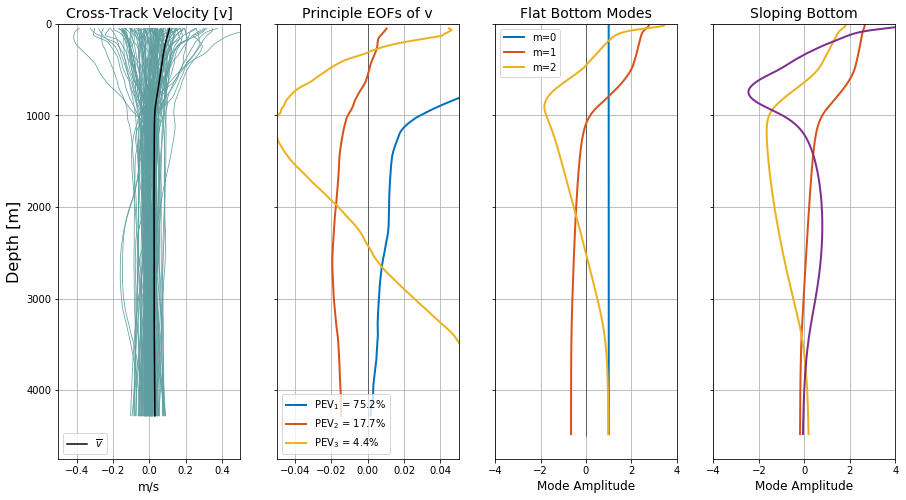

()

In [19]:
# --- plot velocity EOFs 
grid_check = grid[grid_sub_i_3]
mode_colors = ['#0072BD', '#D85319', '#ECB120', '#7E2F8E']
matplotlib.rcParams['figure.figsize'] = (15,8)
f, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(np.shape(V4)[1]):
    ax.plot(V4[:, i], grid_check, color='#5F9EA0', linewidth=0.75)
ax.plot(np.nanmean(np.abs(V4), axis=1), grid_check, color='k', label=r'$\overline{v}$')
ax.set_xlim([-.25, .65])
ax.set_ylim([0, 4750])
ax.set_title('Cross-Track Velocity [v]', fontsize=14)
ax.set_xlabel('m/s', fontsize=12)
ax.set_ylabel('Depth [m]', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.set_xlim([-.5, .5])

ax2.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
ax3.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
colorm = 'r', 'b', 'g'
for i in range(2):
    if np.nanmean(V_Uzqa[0:10, i]) < 0:
        ax2.plot(-1.* np.real(D_Uzqa[i])*np.real(V_Uzqa[:, i]), grid_check, 
                 label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV[i], 3)) + '%', 
                 linewidth=2, color=mode_colors[i])
    else:
        ax2.plot(np.real(D_Uzqa[i])*np.real(V_Uzqa[:, i]), grid_check, 
                 label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV[i], 3)) + '%', 
                 linewidth=2, color=mode_colors[i])    
    ax3.plot(Gz[:, i], grid, label='m=' + str(i), linewidth=2, color=mode_colors[i])
    ax4.plot(F[:, i + 1], grid, label='m=' + str(i), linewidth=2, color=mode_colors[i + 1])
ax2.plot(-10*np.real(D_Uzqa[2])*np.real(V_Uzqa[:, 2]), grid_check, 
         label=r'PEV$_{' + str(2 + 1) + '}$ = ' + str(100 * np.round(PEV[2], 3)) + '%', 
         linewidth=2, color=mode_colors[2])  
ax3.plot(Gz[:, 2], grid, label='m=' + str(2), linewidth=2, color=mode_colors[2])
ax4.plot(F[:, 2 + 1], grid, label='m=' + str(2), linewidth=2, color=mode_colors[2 + 1])    
    
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10, loc=3)
ax2.set_xlim([-.05, .05])
ax2.set_title('Principle EOFs of v', fontsize=14)
# ax2.set_xlabel('m/s', fontsize=16)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10, loc=2)
ax3.set_xlim([-4, 4])
ax3.set_title('Flat Bottom Modes', fontsize=14)
ax3.set_xlabel('Mode Amplitude', fontsize=12)
ax4.set_title('Sloping Bottom', fontsize=14)
ax4.set_xlabel('Mode Amplitude', fontsize=12)
ax4.set_xlim([-4, 4])
ax.grid()
ax2.grid()
ax3.grid()
ax.invert_yaxis()
plot_pro(ax4)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_bats_v_eof_tot.jpg", dpi=300)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


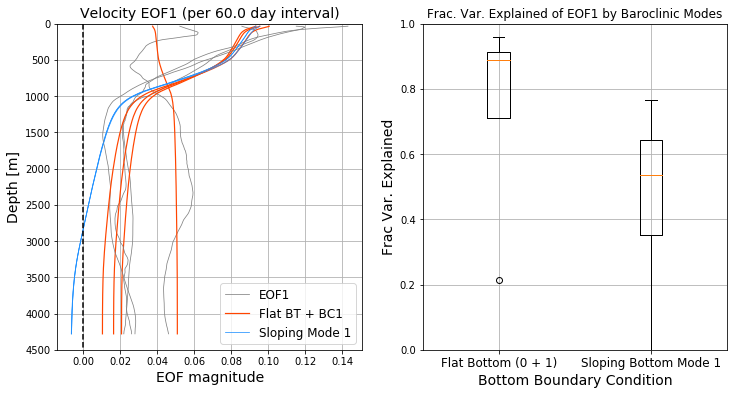

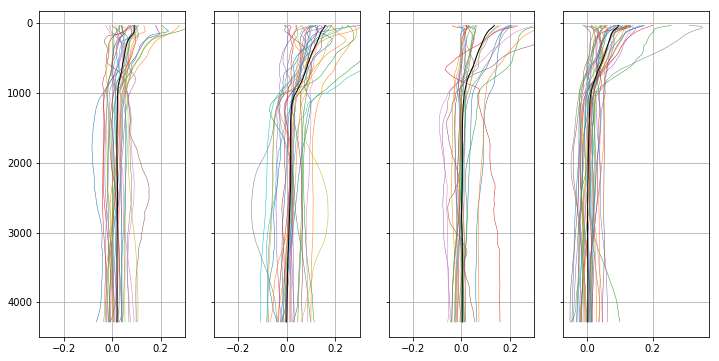

()

In [82]:
# --- EOF of velocity profiles (in two week intervals) ---
def functi_1(p, xe, xb):
    #  This is the target function that needs to be minimized
    fsq = (xe - p*xb)**2
    return fsq.sum()

def functi_2(p, xe, xb, xs):
    #  This is the target function that needs to be minimized
    fsq = (xe - (p[0] * xb + p[1] * xs)) ** 2
    # fsq = (xe - p*xb)**2
    return fsq.sum()

# loop over every two weeks (to obtain statistics)
T_week = np.arange(mw_time_good.min(), mw_time_good.max(), 60)
V4 = V_ordered[check1:check2, :].copy()
for i in range(np.shape(V4)[1]):
    up_avg = np.nanmean(V4[0:50, i])
    if up_avg < 0:
        V4[:, i] = -1.0 * V4[:, i]

checkk = np.zeros(np.shape(V4)[1])
for j in range(np.shape(V4)[1]):
    checkk[j] = np.sum(np.isnan(V4[:, j]))
Uzq = V4[:, checkk < 1].copy()
Time_ordered_c = Time_ordered[checkk < 1]

PEV_per = np.nan * np.ones((len(T_week) - 1, 10))
fvu1_per = np.nan * np.ones(len(T_week) - 1)
fvu2_per = np.nan * np.ones(len(T_week) - 1)
bc1 = Gz[check1:check2, 0]  # flat bottom (modes 0)
bc11 = Gz[check1:check2, 1]  # flat bottom (modes 1)
bc2 = F[check1:check2, 1]  # sloping bottom  (modes 1 + 2 ... there is no barotropic mode)
matplotlib.rcParams['figure.figsize'] = (12,6)
f, (ax, ax1) = plt.subplots(1, 2)
AGz_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
AF_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
eof1_out = np.nan * np.ones((len(grid_check), len(T_week) - 1))
min_fb_amp = np.nan * np.ones((len(T_week) - 1, 2))
for i in range(len(T_week) - 1):
    if i >= (len(T_week) - 2):
        V5 = Uzq[:, (Time_ordered_c > T_week[i])].copy()
    else:
        V5 = Uzq[:, (Time_ordered_c > T_week[i]) & (Time_ordered_c < T_week[i + 1])].copy()
    checkk = np.zeros(np.shape(V5)[1])
    for j in range(np.shape(V5)[1]):
        checkk[j] = np.sum(np.isnan(V5[:, j]))
    V5 = V5[:, checkk < 1]    
    
    print(checkk)
    nq = np.size(V5[0, :])
    avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
    # subtract avg profile for this interval
    Uzqa = V5 - np.transpose(np.tile(avg_Uzq, [nq, 1]))
    cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
    D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
    t1 = np.real(D_Uzqa[0:10])
    # percent explained variance by each eof
    PEV_per[i, :] = (t1 / np.sum(t1))
    # percent variance explained of each eof by baroclinic modes with either bottom boundary condition
    eof1 = np.array(np.real(V_Uzqa[:, 0]))  # eof1 or eof2
    
    # -- minimize mode shapes onto eof shape
    # initial guesses 
    p = np.array([0.8 * eof1.min() / np.max(np.abs(F[:, 1])), 0.8 * eof1.min() / np.max(np.abs(F[:, 1]))])
    p2 = 0.8 * eof1.min() / np.max(np.abs(F[:, 1]))
    ins1 = np.transpose(np.concatenate([eof1, bc1[:, np.newaxis], bc11[:, np.newaxis]], axis=1))
    ins2 = np.transpose(np.concatenate([eof1, bc2[:, np.newaxis]], axis=1))
    min_p1 = fmin(functi_2, p, args=(tuple(ins1)), disp=0)
    min_p2 = fmin(functi_1, p2, args=(tuple(ins2)), disp=0)
    
    # mode 0 + mode 1 (flat bottom)
    eof1_out[:, i] = eof1[:, 0]
    min_fb_amp[i, :] = min_p1
    fvu1_per[i] = 1 - (np.sum((eof1[:, 0] - (bc1 * min_p1[0] + bc11 * min_p1[1])) ** 2) /
                    np.sum((eof1 - np.nanmean(eof1)) ** 2))
    # sloping bottom 
    fvu2_per[i] = 1 - (np.sum((eof1[:, 0] - bc2 * min_p2) ** 2) / np.sum((eof1 - np.nanmean(eof1)) ** 2))

    # plot 
    if np.nanmean(bc1[0:6] * min_p1[0] + bc11[0:6] * min_p1[1]) < 0:  # np.nanmean(eof1[0:20] < 0):
        if fvu1_per[i] > 0:
            ax.plot(-1 * eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot(-1 * (bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(-1 * bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
    else:
        if fvu1_per[i] > 0:
            ax.plot(eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot((bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
ax.plot([0, 0], [0, 4500], color='k', linestyle='--')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1], handles[-4]], [labels[0], labels[1], labels[-4]], fontsize=12)
ax.set_title('Velocity EOF1 (per ' + str(T_week[1] - T_week[0]) + ' day interval)', fontsize=14)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('EOF magnitude', fontsize=14)
ax.set_ylim([0, 4500])
ax.invert_yaxis()

fvu1_per[fvu1_per < 0] = 0.
fvu2_per[fvu2_per < 0] = 0.

# ax1.boxplot([data1, data2])
# np.concatenate((fvu1_per[:, None], fvu2_per[:, None]), axis=1)
ax1.boxplot([fvu1_per[~np.isnan(fvu1_per)], fvu2_per[~np.isnan(fvu2_per)]])  # fvu1_per[:, None]
ax1.set_ylim([0, 1])
ax1.set_title('Frac. Var. Explained of EOF1 by Baroclinic Modes')
ax1.set_xlabel('Bottom Boundary Condition', fontsize=14)
ax1.set_ylabel('Frac Var. Explained', fontsize=14)
ax1.set_xticklabels(['Flat Bottom (0 + 1)', 'Sloping Bottom Mode 1'], fontsize=12)
# ax2.set_title('Bottom Boundary Condition')
# ax2.set_ylabel('Frac Var. Explained by Mode Shapes')
# ax2.set_ylim([0, 1])
ax.grid()
plot_pro(ax1)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_bats_v_eof1.jpg", dpi=300)

f, ax = plt.subplots(1, 4, sharey=True)
for i in range(4):  #len(T_week) - 1):
    if i >= (len(T_week) - 2):
        V5 = Uzq[:, (Time_ordered_c > T_week[i])].copy()
    else:
        V5 = Uzq[:, (Time_ordered_c > T_week[i]) & (Time_ordered_c < T_week[i + 1])].copy()
    checkk = np.zeros(np.shape(V5)[1])
    for j in range(np.shape(V5)[1]):
        checkk[j] = np.sum(np.isnan(V5[:, j]))
    V5 = V5[:, checkk < 1]    
    
    for j in range(np.shape(V5)[1]):
        ax[i].plot(V5[:, j], grid_check, linewidth=0.5)
    
    ax[i].plot(np.nanmean(V5, axis=1), grid_check, linewidth=1, color='k')
ax[0].invert_yaxis()    
ax[0].grid()
ax[0].set_xlim([-.3, .3])
ax[1].grid()
ax[1].set_xlim([-.3, .3])
ax[2].grid()
ax[2].set_xlim([-.3, .3])
plot_pro(ax[3])    

In [70]:
print(np.sum((eof1_out[:, 0] - np.nanmean(eof1_out[:, 0]))**2))
print(np.sum((eof1_out[:, 1] - np.nanmean(eof1_out[:, 1]))**2))
print(np.sum((eof1_out[:, 2] - np.nanmean(eof1_out[:, 2]))**2))
i

0.0994839346989
0.470139521853
0.653590066827


4

The figure above addresses the de La Lama conclusion and compares which structure captures more of the variance of the horizontal velocity profiles (structure 1 = BT + BC1 (flat bottom), structure 2 = BC1 (sloping bottom) 

In [20]:
# --- Isolate eddy dives ---
# 2015 - dives 62, 63 ,64
# ed_prof_in = np.where(((x.dives) >= 62) & ((x.dives) <= 66))[0]
ed_in = np.where((Info3 >= 62) & (Info3 <= 70))[0]
ed_time_s = datetime.date.fromordinal(np.int(Time_ordered[ed_in[0]]))
ed_time_e = datetime.date.fromordinal(np.int(Time_ordered[ed_in[-1] + 1]))

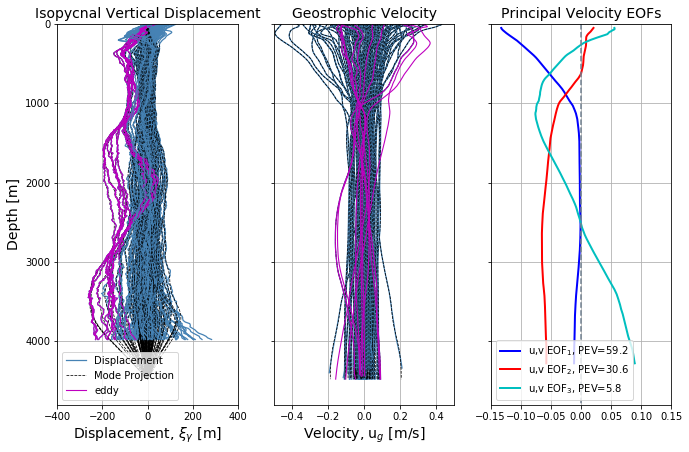

()

In [151]:
# plot eta 
matplotlib.rcParams['figure.figsize'] = (11,7)
f_eta, (ax1, ax0, ax2) = plt.subplots(1, 3, sharey=True)
pzmax = -25
ax1.plot(mw_eta_3_good[0:pzmax, 0], grid[0:pzmax], color='#4682B4', linewidth=1.25, label='Displacement')
ax1.plot(Eta_m[:, 0], grid, color='k', linestyle='--', linewidth=.75, label='Mode Projection')
ax0.plot(mw_v_good[:, 0], grid, color='#4682B4', linewidth=1.25, label='Velcocity')
ax0.plot(V_m[:, 0], grid, color='k', linestyle='--', linewidth=.75, label='Mode Projection')
for j in range(num_profs):
    ax1.plot(mw_eta_3_good[0:pzmax, j], grid[0:pzmax], color='#4682B4', linewidth=1.25)
    ax1.plot(Eta_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
    if good_ke_prof[j] > 0:
        ax0.plot(mw_v_good[:, j], grid, color='#4682B4', linewidth=1.25)
        ax0.plot(V_m[:, j], grid, color='k', linestyle='--', linewidth=.75)

ax1.plot(Eta_ordered[0:pzmax, ed_in[1]], grid[0:pzmax], color='m', linewidth=1.1, label='eddy')        
for k in range(len(ed_in)):
    ax1.plot(Eta_ordered[0:pzmax, ed_in[k]], grid[0:pzmax], color='m', linewidth=1.1)
    ax0.plot(V_ordered[:, ed_in[k]], grid, color='m', linewidth=1.1)
# before eddy
pre_ed = np.where((mw_prof_good >= 55) & (mw_prof_good <= 62))[0]
for k in range(len(pre_ed)):
    ax1.plot(mw_eta_3_good[0:pzmax, pre_ed[k]], grid[0:pzmax], color='#4682B4', linewidth=1.1)
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend([handles[0]], [labels[0]], fontsize=10)   
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
# ax0.text(150, 4500, str(num_profs) + ' Profiles')
ax1.set_xlim([-400, 400]) 
ax1.set_ylim([0, 4800])
ax1.invert_yaxis()
ax1.grid()
ax0.set_xlim([-.5, .5])
ax0.set_title("Geostrophic Velocity", fontsize=14)  # (" + str(num_profs) + 'profiles)' )
ax0.set_xlabel(r'Velocity, u$_g$ [m/s]', fontsize=14)
ax1.set_xlabel(r'Displacement, $\xi_{\gamma}$ [m]', fontsize=14)
ax1.set_title(r'Isopycnal Vertical Displacement', fontsize=14)
ax1.set_ylabel('Depth [m]', fontsize=14)
ax0.grid()

mo_col = 'b', 'r' ,'c'
for i in range(3):
#     ax2.plot(V_Uzqa[:, i], grid_check, label=r'u eof$_{' + str(i + 1) + '}$ PEV = ' + str(100 * np.round(PEV[i], 3)) + '%',
#                 linewidth=2, color=mo_col[i])
    ax2.plot(UU3[:, i], grid[grid_sub_i_3], color=mo_col[i], linewidth=2,
            label=r'u,v EOF$_{' + str(i+1) +'}$, PEV=' + str(np.round(frac_eof_uv[i]*100,1)))
ax2.plot([0, 0], [0, 5000], linestyle='--', color='#708090')
ax2.set_title('Principal Velocity EOFs', fontsize=14)
# ax2.set_xlabel('EOF magnitude', fontsize=14)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
ax2.set_xlim([-.15, .15])
    
plot_pro(ax2)    
# f_eta.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_15_eta_v_eof.jpg", dpi=400)

In [47]:
np.shape(Amp1_eta)

(128,)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


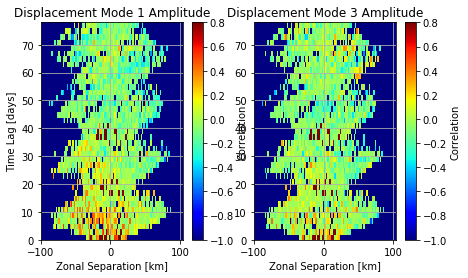

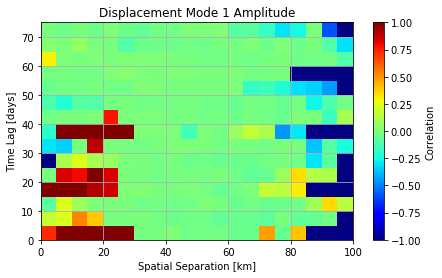

()

In [50]:
# Mode Amplitude Correlations 
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (np.nanmean(prof_lon, axis=0) - ref_lon)
y = 1852 * 60 * (np.nanmean(prof_lat, axis=0) - ref_lat)
x_tile = np.tile(x, (len(x), 1))
y_tile = np.tile(y, (len(y), 1))
time_tile = np.tile(prof_time, (len(prof_time), 1))
dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
time_lag = np.abs(time_tile - time_tile.T)

# redo with only zonal separation
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (np.nanmean(prof_lon, axis=0) - ref_lon) / 1000
y = 1852 * 60 * (np.nanmean(prof_lat, axis=0) - ref_lat) / 1000
t = prof_time.copy()
AG_i = AG_ind[1, :]
AG_ii = AG_ind[3, :]

# distances apart
# dist_x = np.nan * np.zeros((len(x), len(x)))
# time_l = np.nan * np.zeros((len(x), len(x)))
for i in range(len(x) - 1):
    if i < 1:
        dist_x = x[i+1:] - x[i]
        dist_y = y[i+1:] - y[i]
        dist_t = np.sqrt(dist_x**2 + dist_y**2)
        time_l = np.abs(t[i] - t[i+1:])
        AG_count = np.array((AG_i[i] * np.ones(len(x[i+1:])), AG_i[i+1:]))
        AG_count2 = np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))
    else:
        dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
        dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
        dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i + 1:] - y[i])**2)))
        time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
        AG_count = np.concatenate((AG_count, np.array((AG_i[i] * np.ones(len(x[i + 1:])), AG_i[i + 1:]))), axis=1)
        AG_count2 = np.concatenate((AG_count2, 
                                    np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))), axis=1)
        
# define each box as all points that fall within a time and space lag
dist_win = np.arange(-100, 105, 2)
dist_t_win = np.arange(0, 105, 5)
t_win = np.arange(0, 80, 2)
t_t_win = np.arange(0, 80, 5)
corr_i_z = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_z2 = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))
for dd in range(len(dist_win) - 1):
    for tt in range(len(t_win) - 1):
        in_box = np.where((dist_x > dist_win[dd]) & (dist_x < dist_win[dd + 1]) & 
                          (time_l > t_win[tt]) & (time_l < t_win[tt + 1]))[0]
        if len(in_box) > 4:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(len(inski))
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z[tt, dd] = (1 / (n * variance)) * np.nansum(covi)

            inski_with = AG_count2[:, in_box]
            inski = np.unique(AG_count2[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z2[tt, dd] = (1 / (n * variance)) * np.nansum(covi)   
            
for dd in range(len(dist_t_win) - 1):
    for tt in range(len(t_t_win) - 1):
        in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                            (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
        if len(in_box) > 5:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_all[tt, dd] = (1 / (n * variance)) * np.nansum(covi)    
  
plt.rcParams['figure.figsize'] = 7, 4
f, (ax1, ax2) = plt.subplots(1, 2)
pa = ax1.pcolor(dist_win, t_win, corr_i_z, vmin=-1, vmax=.8, cmap='jet')
pa2 = ax2.pcolor(dist_win, t_win, corr_i_z2, vmin=-1, vmax=.8, cmap='jet')
ax1.set_xlabel('Zonal Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax2.set_xlabel('Zonal Separation [km]')
ax1.set_title('Displacement Mode 1 Amplitude')
ax2.set_title('Displacement Mode 3 Amplitude')
f.colorbar(pa, ax=ax1, label='Correlation')
f.colorbar(pa2, ax=ax2, label='Correlation')
ax1.grid()
plot_pro(ax2)

f, ax1 = plt.subplots()
pa = ax1.pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap='jet')
ax1.set_xlabel('Spatial Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax1.set_title('Displacement Mode 1 Amplitude')
plt.colorbar(pa, label='Correlation')
plot_pro(ax1)            

In [152]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_0 = HKE_per_mass.copy()
PE_per_mass_0 = PE_per_mass.copy()
# HKE_per_mass = HKE_per_mass[:, np.where(good_ke_prof > 0)[0]]
# PE_per_mass = PE_per_mass[:, np.where(good_ke_prof > 0)[0]]
calmer = np.where((mw_prof_good < 60) | (mw_prof_good >= 71) & (good_ke_prof > 0))[0]  # excl. labby
# calmer = np.arange(0, np.int(np.sum(good_ke_prof)))
avg_PE = np.nanmean(PE_per_mass[:, calmer], 1)
avg_KE = np.nanmean(HKE_per_mass[:, calmer], 1)
# --- eddy kinetic and potential energy
PE_ed = np.nanmean(PE_per_mass[:, ed_in[0]:ed_in[-1]], axis=1)
KE_ed = np.nanmean(HKE_per_mass[:, ed_in[0]:ed_in[-1]], axis=1)

# --- ENERGY parameters ---
vert_wavenumber = f_ref / c[1:]
dk_ke = 1000 * f_ref / c[1]
k_h = 1e3 * (f_ref / c[1:]) * np.sqrt(avg_KE[1:] / avg_PE[1:])
PE_SD, PE_GM, GMPE, GMKE, n2_decay = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(N2_tot)), f_ref)
vert_wave = sc_x / 1000
alpha = 10
mu = 1.88e-3 / (1 + 0.03222 * np.nanmean(theta_avg, axis=1) +
                0.002377 * np.nanmean(theta_avg, axis=1) * np.nanmean(theta_avg, axis=1))
nu = mu / gsw.rho(np.nanmean(sa_avg, axis=1), np.nanmean(ct_avg, axis=1), grid_p)
avg_nu = np.nanmean(nu)


# --- most and least energetic profiles
KE_i = HKE_per_mass[:, calmer]
PE_i = PE_per_mass[:, calmer]
KE_it = np.nan * np.ones(KE_i.shape[1])
PE_it = np.nan * np.ones(KE_i.shape[1])
for i in range(KE_i.shape[1]):
    KE_it[i] = np.trapz(KE_i[1:, i] + PE_i[1:, i], 1000 * f_ref / c[1:])
    PE_it[i] = np.trapz(PE_i[1:, i], 1000 * f_ref / c[1:])
KE_i_max = np.where(KE_it == np.nanmax(KE_it))[0]
KE_i_min = np.where(KE_it == np.nanmin(KE_it))[0]
PE_i_max = np.where(PE_it == np.nanmax(PE_it))[0]
PE_i_min = np.where(PE_it == np.nanmin(PE_it))[0]
k_h_max = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_max]) / np.squeeze(PE_i[1:, KE_i_max]))
k_h_min = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_min]) / np.squeeze(PE_i[1:, KE_i_min]))

In [153]:
# --- LOAD in Comparison DATA ---
# --- load in Station BATs PE Comparison ---
pkl_file = open('/Users/jake/Desktop/bats/station_bats_pe_jun04_19.pkl', 'rb')  # update jan 2019
SB = pickle.load(pkl_file)
pkl_file.close()
sta_bats_pe = SB['PE_by_season']
sta_bats_c = SB['c']
sta_bats_depth = SB['depth']
sta_bats_f = np.pi * np.sin(np.deg2rad(31.6)) / (12 * 1800)
sta_bats_dk = sta_bats_f / sta_bats_c[1]
sta_bats_pe_total = np.nanmean(np.concatenate((np.nanmean(sta_bats_pe[0], axis=1)[:, None],
                                    np.nanmean(sta_bats_pe[1], axis=1)[:, None],
                                    np.nanmean(sta_bats_pe[2], axis=1)[:, None]), axis=1), axis=1)
test = np.concatenate((sta_bats_pe[0], sta_bats_pe[1], sta_bats_pe[2]), axis=1)
sta_bats_n2_1 = SB['N2_per_season'][:, 1]
PE_SD_bats, PE_GM_bats, GMPE_bats, GMKE_bats, n2_decay = PE_Tide_GM(rho0, sta_bats_depth,
                                                          len(sta_bats_pe_total), sta_bats_n2_1[:, None], sta_bats_f)

# seasonal and variable spread at bats station for each mode
sta_max = np.nan * np.ones(len(sc_x))
sta_min = np.nan * np.ones(len(sc_x))
dg_per_max = np.nan * np.ones(len(sc_x))
dg_per_min = np.nan * np.ones(len(sc_x))
for i in range(1, mmax+1):
    test1 = np.nanmean(sta_bats_pe[0][i, :])
    test2 = np.nanmean(sta_bats_pe[1][i, :])
    test3 = np.nanmean(sta_bats_pe[2][i, :])
    
    test1_min = np.nanmean(sta_bats_pe[0][i, sta_bats_pe[0][i, :] < test1])
    test2_min = np.nanmean(sta_bats_pe[1][i, sta_bats_pe[1][i, :] < test2])
    test3_min = np.nanmean(sta_bats_pe[2][i, sta_bats_pe[2][i, :] < test3])
    test1_max = np.nanmean(sta_bats_pe[0][i, sta_bats_pe[0][i, :] > test1])
    test2_max = np.nanmean(sta_bats_pe[1][i, sta_bats_pe[1][i, :] > test2])
    test3_max = np.nanmean(sta_bats_pe[2][i, sta_bats_pe[2][i, :] > test3])
    
    sta_max[i - 1] = np.max([test1_max, test2_max, test3_max])
    sta_min[i - 1] = np.min([test1_min, test2_min, test3_min])
#     sta_max[i - 1] = np.nanmax(test[i, :])
#     sta_min[i - 1] = np.nanmin(test[i, :])
    dg_per_max[i - 1] = np.nanmax(PE_per_prof[i, :])
    dg_per_min[i - 1] = np.nanmin(PE_per_prof[i, :])

In [314]:
np.shape(V_ordered)

(450, 132)

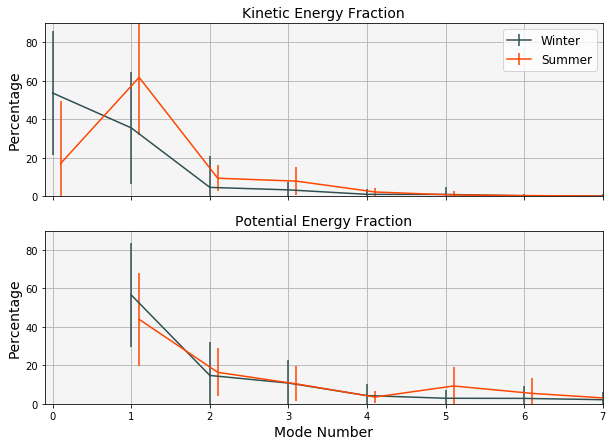

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: Mean of empty slice


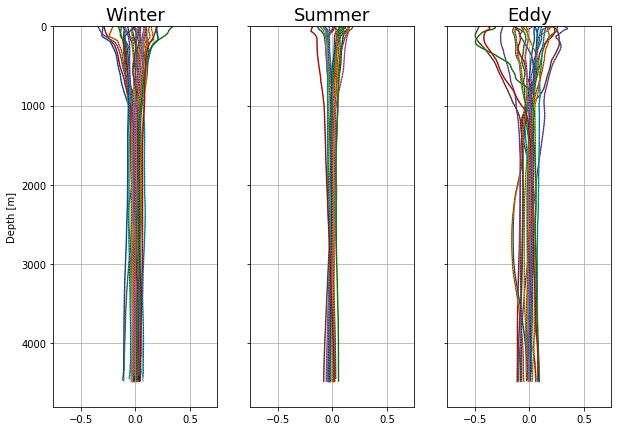

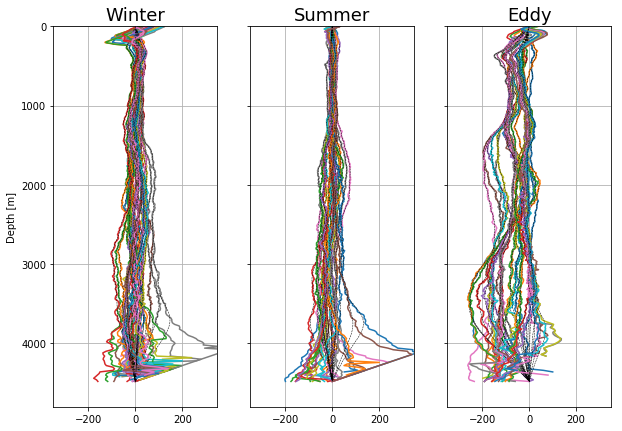

()

In [154]:
# --- Partition KE, PE by season (like bats) ---

# OLD three background partition 
# # Summer = June 1 - Sept 15
# d_sum = np.where(((Time_ordered > bd1) & (Time_ordered < bd2)))[0]  # & (Time_ordered < bd2)
# # Winter1 = (Feb 2 - June 1)
# d_win1 = np.where((Time_ordered < bd1) & ((Info3 < 60) | (Info3 > 71)))[0]
# # Winter2 = (Sept 15 - Nov 5)
# d_win2 = np.where(Time_ordered > bd2)[0]
# # Eddy
# d_eddy = np.where((Info3 >= 60) & (Info3 <= 71))[0]
# # --- background key 
# bckgrds = [d_win1, d_sum, d_win2, d_eddy]  # KEY!! 4, sets of profiles (OLD)
# bckgrds_key = 'Winter', 'Summer', 'Fall', 'Eddy'

# NEW two background partition 
boundy1 = 735703  # april 15
boundy2 = 735841  # (735841  # aug 31)
# Winter -- start (Feb) through July 1
d_winter = np.where(Time_ordered < (boundy1))[0]  
# Summer = July 1 - through end (Nov)
d_summer = np.where(Time_ordered > (boundy2))[0] 
# Eddy
d_eddy = np.where((Time_ordered > (735703)) & (Time_ordered < (735750)))[0]  # april 12 - june1
# --- background key 
bckgrds = [d_winter, d_summer, d_eddy]  
bckgrds_key = 'Winter', 'Summer', 'Eddy'

k_h_win1 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
k_h_sum = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))
# k_h_win2 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[2]], axis=1) /
#                                            np.nanmean(PE_per_mass_0[1:, bckgrds[2]], axis=1))
k_h_eddy = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[2]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[2]], axis=1))

# --- RATIO of KE_i / KE_total
KE_fraction_w1_t = 100 * HKE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[0]],
                                                                         axis=0), (nmodes, 1))
KE_w1_std = np.nanstd(KE_fraction_w1_t, axis=1)
KE_fraction_s_t = 100 * HKE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[1]],
                                                                        axis=0), (nmodes, 1))
KE_s_std = np.nanstd(KE_fraction_s_t, axis=1)
# KE_fraction_w2_t = 100 * HKE_per_mass_0[:, bckgrds[2]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[2]],
#                                                                          axis=0), (nmodes, 1))
# KE_w2_std = np.nanstd(KE_fraction_w2_t, axis=1)
KE_fraction_ed_t = 100 * HKE_per_mass_0[:, bckgrds[2]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[2]],
                                                                         axis=0), (nmodes, 1))
KE_ed_std = np.nanstd(KE_fraction_ed_t, axis=1)

# --- KE percent in each mode 
KE_fraction_w1 = 100 * np.nanmean(HKE_per_mass_0[:, bckgrds[0]], 
                            axis=1) / np.nansum(np.nanmean(HKE_per_mass_0[:, bckgrds[0]], axis=1))
KE_fraction_s = 100 * np.nanmean(HKE_per_mass_0[:, bckgrds[1]], 
                            axis=1) / np.nansum(np.nanmean(HKE_per_mass_0[:, bckgrds[1]], axis=1))
# KE_fraction_w2 = 100 * np.nanmean(HKE_per_mass_0[:, bckgrds[2]], 
#                             axis=1) / np.nansum(np.nanmean(HKE_per_mass_0[:, bckgrds[2]], axis=1))
KE_fraction_ed = 100 * np.nanmean(HKE_per_mass_0[:, bckgrds[2]], 
                            axis=1) / np.nansum(np.nanmean(HKE_per_mass_0[:, bckgrds[2]], axis=1))

# fraction PE partition for each profile 
PE_fraction_w1_t = 100 * PE_per_mass_0[1:, bckgrds[0]] / np.tile(np.nansum(PE_per_mass_0[1:, bckgrds[0]],
                                                                        axis=0), (nmodes - 1, 1))
PE_w1_std = np.nanstd(PE_fraction_w1_t, axis=1)
PE_fraction_s_t = 100 * PE_per_mass_0[1:, bckgrds[1]] / np.tile(np.nansum(PE_per_mass_0[1:, bckgrds[1]],
                                                                       axis=0), (nmodes - 1, 1))
PE_s_std = np.nanstd(PE_fraction_s_t, axis=1)
PE_fraction_ed_t = 100 * PE_per_mass_0[1:, bckgrds[2]] / np.tile(np.nansum(PE_per_mass_0[1:, bckgrds[2]],
                                                                        axis=0), (nmodes - 1, 1))
PE_ed_std = np.nanstd(PE_fraction_ed_t, axis=1)

# --- PE percent in each mode 
PE_fraction_w1 = 100 * np.nanmean(PE_per_mass_0[1:, bckgrds[0]], 
                            axis=1) / np.nansum(np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
PE_fraction_s = 100 * np.nanmean(PE_per_mass_0[1:, bckgrds[1]], 
                            axis=1) / np.nansum(np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))
PE_fraction_ed = 100 * np.nanmean(PE_per_mass_0[1:, bckgrds[2]], 
                            axis=1) / np.nansum(np.nanmean(PE_per_mass_0[1:, bckgrds[2]], axis=1))
    
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
matplotlib.rcParams['figure.figsize'] = (10,7)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_facecolor('#F5F5F5')
ax1.errorbar(np.arange(0, nmodes), KE_fraction_w1, yerr=KE_w1_std, color=cols[0], label='Winter')
ax1.errorbar(np.arange(0, nmodes) + .1, KE_fraction_s, yerr=KE_s_std, color=cols[1], label='Summer')
# ax1.errorbar(np.arange(0, nmodes) + .2, KE_fraction_w2, yerr=KE_w2_std, color=cols[2], label='Fall')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12)
ax1.set_ylim([0, 90])
ax1.set_xlim([-.1, 7])
ax1.set_title('Kinetic Energy Fraction', fontsize=14)
ax1.set_ylabel('Percentage', fontsize=14)
ax1.grid()
ax2.set_facecolor('#F5F5F5')
ax2.errorbar(np.arange(1, nmodes), PE_fraction_w1, yerr=PE_w1_std, color=cols[0])
ax2.errorbar(np.arange(1, nmodes) + .1, PE_fraction_s, yerr=PE_s_std, color=cols[1])
# ax2.errorbar(np.arange(1, nmodes) + .2, PE_fraction_w2, yerr=PE_w2_std, color=cols[2])

ax2.set_ylim([0, 90])
ax2.set_title('Potential Energy Fraction', fontsize=14)
ax2.set_ylabel('Percentage', fontsize=14)
ax2.set_xlabel('Mode Number', fontsize=14)
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_energy_fracs.jpg", dpi=300)

# velocity profiles by season 
f, ax = plt.subplots(1, len(bckgrds), sharey=True)
for i in range(len(bckgrds)):
    vin = V_ordered[:, bckgrds[i]]
    vin_m = Vm_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        if (i > 0) & (np.abs(np.nanmean(vin[440:, j])) < 0.15):
            ax[i].plot(vin[:, j], grid)
            ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
            # print(j)
        elif i <= 0:
            ax[i].plot(vin[:, j], grid)
            ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)            
    ax[i].set_xlim([-0.75, 0.75])
    ax[i].set_title(bckgrds_key[i], fontsize=18)
ax[0].set_ylabel('Depth [m]')    
ax[0].set_ylim([0, 4800])
ax[0].grid()
ax[1].grid()
# ax[2].grid()
ax[0].invert_yaxis()
plot_pro(ax[2])
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_bats_v_seasonal.jpg", dpi=300)

# displacement profiles by season 
f, ax = plt.subplots(1, len(bckgrds), sharey=True)
for i in range(len(bckgrds)):
    vin = Eta_ordered[:, bckgrds[i]]
    vin_m = Etam_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-350, 350])
    ax[i].set_title(bckgrds_key[i], fontsize=18)
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim([0, 4800])
ax[0].grid()
ax[1].grid()
# ax[2].grid()
ax[0].invert_yaxis()
plot_pro(ax[2])
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_bats_eta_seasonal.jpg", dpi=300)

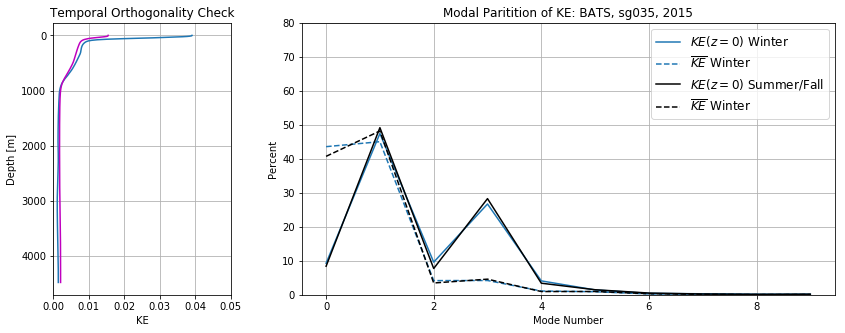

()

In [290]:
# surface kinetic energy 
# temporal orthogonality of the modes 
T_1 = np.nan * np.ones((len(grid), len(bckgrds)))
T_2 = np.nan * np.ones((len(bckgrds), len(grid), np.shape(AGz_ordered)[0]))
T_2_check = np.nan * np.ones((len(grid), len(bckgrds)))
for m in range(len(bckgrds)):
    L = len(AGz_ordered[0, bckgrds[m]])
    mm = np.nan * np.ones((L, len(grid), np.shape(AGz_ordered)[0]))
    mm2 = np.nan * np.ones((L, len(grid), np.shape(AGz_ordered)[0]))
    for j in range(L):  # loop over each time 
        for i in range(np.shape(AGz_ordered)[0]):  # loop over each mode 
            mm[j, :, i] = AGz_ordered[i, j]*Gz[:, i]
            mm2[j, :, i] = (AGz_ordered[i, j]**2)*(Gz[:, i]**2)
    
    # outer mean is avg across time ( inner sum is acoss modes)    
    T_1[:, m] = np.nanmean(np.squeeze(np.nansum(mm, axis=2)**2), axis=0) 
    # outer mean is avg across time
    T_2[m, : ,:] = np.nanmean(mm2, axis=0)
    T_2_check[:, m] = np.nanmean(np.nansum(mm2, axis=2), axis=0)

from matplotlib import gridspec
fig0 = plt.figure(figsize=(14, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
ax0 = plt.subplot(gs[0])
ax = plt.subplot(gs[1])

ax0.plot(T_1[:, 0], grid)
ax0.plot(T_2_check[:, 0], grid, color='m')
ax0.set_xlim([0, 0.05])
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('KE')
ax0.set_title('Temporal Orthogonality Check')
ax0.invert_yaxis()
ax0.grid()

ax.plot(np.arange(0, 10), 100*T_2[0, 0, 0:10]/np.nansum(T_2[0, 0, :]), label=r'$KE(z=0)$ Winter')
T_2_mean_0 = np.nanmean(np.squeeze(T_2[0, :, :]), axis=0)
ax.plot(np.arange(0, 10), 100*(T_2_mean_0[0:10]/np.nansum(T_2_mean_0)), linestyle='--', color='#1f77b4', label=r'$\overline{KE}$ Winter')

ax.plot(np.arange(0, 10), 100*T_2[1, 0, 0:10]/np.nansum(T_2[1, 0, :]), color='k', label=r'$KE(z=0)$ Summer/Fall')
T_2_mean_2 = np.nanmean(np.squeeze(T_2[1, :, :]), axis=0)
ax.plot(np.arange(0, 10), 100*(T_2_mean_2[0:10]/np.nansum(T_2_mean_2)), linestyle='--', color='k', label=r'$\overline{KE}$ Winter')
ax.set_xlabel('Mode Number')
ax.set_ylabel('Percent')
ax.set_title('Modal Paritition of KE: BATS, sg035, 2015')
ax.set_ylim([0, 80])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)
plot_pro(ax)
# fig0.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_15_surface_ke.jpg", dpi=300)

In [158]:
print(PE_fraction_w1[0:3])
print(PE_fraction_s[0:3])
# print(PE_fraction_w2[0:3])
print(np.sum(PE_fraction_w1[0:3]))
print(np.sum(PE_fraction_s[0:3]))
# print(np.sum(PE_fraction_w2[0:3]))

print(KE_fraction_w1[0:4])
print(KE_fraction_s[0:4])
print(np.sum(KE_fraction_w1[0:4]))
print(np.sum(KE_fraction_s[0:4]))

[ 56.61047991  14.74490782  10.79287487]
[ 43.9564686   16.37949502  10.36326714]
82.1482626017
70.6992307708
[ 53.71581394  35.56359473   4.60630499   3.31614138]
[ 16.99475821  61.85790969   9.3731606    7.87417995]
97.2018550466
96.1000084406


/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


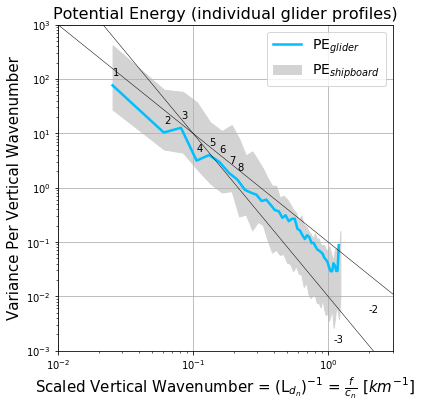

()

In [291]:
matplotlib.rcParams['figure.figsize'] = (6, 6)
f, ax = plt.subplots()
ax.fill_between(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], sta_min / sta_bats_dk, sta_max / sta_bats_dk,
                 label='PE$_{shipboard}$', color='#D3D3D3')
# ax.plot(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], np.nanmean(sta_bats_pe[0][1:mmax+1, :], axis=1) / sta_bats_dk, color='#D3D3D3', linewidth=2.5 )
# ax.plot(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], np.nanmean(sta_bats_pe[1][1:mmax+1, :], axis=1) / sta_bats_dk, color='#D3D3D3', linewidth=2.5 )
# ax.plot(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], np.nanmean(sta_bats_pe[2][1:mmax+1, :], axis=1) / sta_bats_dk, color='#D3D3D3', linewidth=2.5 )



# for i in range(np.shape(PE_per_prof)[1]):
#     ax.plot(sc_x, PE_per_prof[1:, i] / dk, color='#00BFFF', label='PE$_{dg}$', linewidth=2.5)
PE_per_prof_good = (PE_per_prof[1, :] / dk) < 1 * 10**6
ax.plot(sc_x, np.nanmean(PE_per_prof[1:, PE_per_prof_good], axis=1) / dk, color='#00BFFF', label='PE$_{glider}$', linewidth=2.5)
# ax.scatter(sc_x, np.nanmean(PE_per_prof[1:, :], axis=1) / dk, color='#00BFFF', s=20)

modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
for i in range(len(modeno)):
    ax.text(sc_x[i], (np.nanmean(PE_per_prof[i + 1, PE_per_prof_good]) / dk) + 
             (np.nanmean(PE_per_prof[i + 1, PE_per_prof_good]) / dk) / 2, modeno[i], color='k')   

# ax.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
# ax.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
# ax.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
# ax.text(2*10**0, 3*10**-3, '-2', fontsize=13)
ax.plot([10**-2, 10**1], [10**4, 10**-5], color='k', linewidth=0.5)
ax.text(1.1*10**0, 1.4*10**-3, '-3', fontsize=10)
ax.plot([10**-2, 10**1], [10**3, 10**-3], color='k', linewidth=0.5)
ax.text(2*10**0, 5*10**-3, '-2', fontsize=10)
ax.set_xlim([10 ** -2, 3 * 10 ** 0])
ax.set_ylim([10 ** (-3), 1 * 10 ** 3])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Potential Energy (individual glider profiles)', fontsize=16)
ax.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=15)
ax.set_ylabel('Variance Per Vertical Wavenumber', fontsize=15)
plot_pro(ax)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_bats_energy_inds.jpg", dpi=300)

In [40]:
datetime.date.fromordinal(np.int(boundy2))

datetime.date(2015, 8, 31)

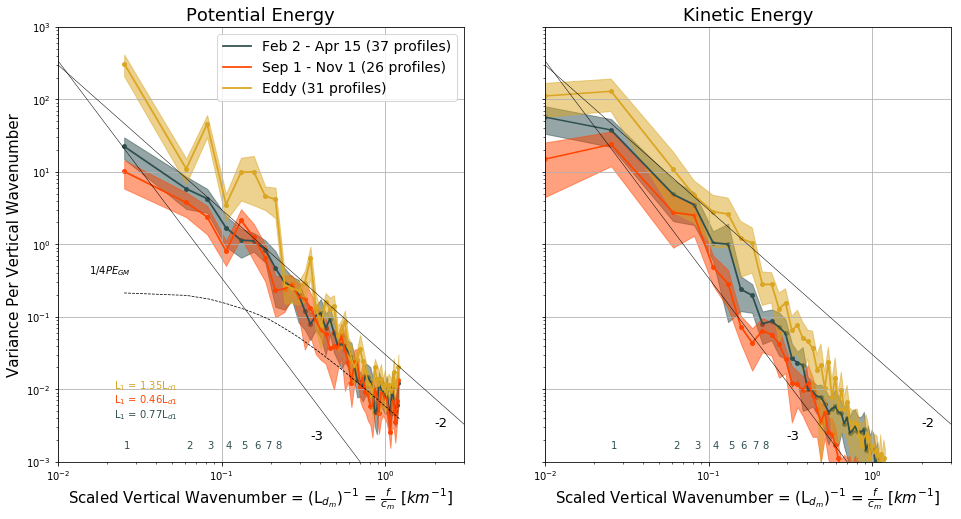

In [344]:
# --- PLOT ENERGY BY SEASON
matplotlib.rcParams['figure.figsize'] = (16,8)

f_s_en, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# labs = 'Feb-May (' + str(np.shape(d_win1)[0]) + ' profiles)', 'Jun-Sept (' + str(np.shape(d_sum)[0]) + ' profiles)',\
#         'Sept-Nov (' + str(np.shape(d_win2)[0]) + ' profiles)', 'Eddy'
labs = 'Feb 2 - Apr 15 (' + str(np.shape(d_winter)[0]) + ' profiles)', 'Sep 1 - Nov 1 (' + str(np.shape(d_summer)[0]) + ' profiles)', 'Eddy (' + str(np.shape(d_eddy)[0]) + ' profiles)'    

lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds)))
x_min = 10 ** (-2)
y_min = 10 ** (-3)
ylab = np.array([0, 2.5*10**(-3), 6*10**(-3)])
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    
    # confidence intervals
    pmean = np.nanmean(PE_per_mass_0[1:, inn] / dk, axis=1)
    pp = PE_per_mass_0[1:, inn] / dk 
    pstd = np.nanstd(PE_per_mass_0[1:, inn] / dk, axis=1)
    low_ci = pmean - 1.960*(pstd/np.sqrt(len(PE_per_mass_0[1, inn])))
    high_ci = pmean + 1.960*(pstd/np.sqrt(len(PE_per_mass_0[1, inn])))
    
    ax1.fill_between(sc_x, low_ci, high_ci, color=cols[i], alpha=0.5) 
    ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    
    # confidence intervals
    if i == 1:
        # innn = np.concatenate((np.arange(80, 110), np.arange(120, 130)))
        innn = np.concatenate((inn[0:20], inn[23:]))
        kmean = np.nanmean(HKE_per_mass_0[:, innn] / dk, axis=1)
        # kk = HKE_per_mass_0[:, innn] / dk 
        kstd = np.nanstd(HKE_per_mass_0[:, innn] / dk, axis=1)
    elif i == 2:
        # innn = np.concatenate((np.arange(80, 110), np.arange(120, 130)))
        innn = np.concatenate((inn[0:15], inn[15:25], inn[28:]))
        kmean = np.nanmean(HKE_per_mass_0[:, innn] / dk, axis=1)
        # kk = HKE_per_mass_0[:, inn] / dk 
        kstd = np.nanstd(HKE_per_mass_0[:, innn] / dk, axis=1)        
    else:
        innn = inn
        kmean = np.nanmean(HKE_per_mass_0[:, innn] / dk, axis=1)
        # kk = HKE_per_mass_0[:, innn] / dk 
        kstd = np.nanstd(HKE_per_mass_0[:, innn] / dk, axis=1)
    low_ci = kmean - 1.960*(kstd/np.sqrt(len(HKE_per_mass_0[1, innn])))
    high_ci = kmean + 1.960*(kstd/np.sqrt(len(HKE_per_mass_0[1, innn])))
    
    ax2.fill_between(np.concatenate((np.array([10**-2])[:, None], sc_x[:, None]), axis=0)[:, 0],
                     low_ci, high_ci, color=cols[i], alpha=0.5) 
    ax2.plot(sc_x, np.nanmean(HKE_per_mass_0[1:, innn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax2.scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, innn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, innn], axis=1)[0:2] / dk, color=cols[i], linewidth=1.5)
    ax2.scatter(10**-2, np.nanmean(HKE_per_mass_0[:, innn], axis=1)[0] / dk, color=cols[i], s=scz[i]*1.5, facecolors='none')
    seasonal_PE_output[1:, i] = np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[1:, i] = np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[0, i] = np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk
    
    hl = np.sqrt(np.nanmean(PE_per_mass_0[1, inn]) / np.nanmean(HKE_per_mass_0[1, inn]))  # hor length scale as ratio to L_d1 (PE/KE = (L/L_d)^2)
    ax1.text(x_min + 1.2*x_min, y_min + 3*y_min + (ylab[i]), r'L$_1$ = ' + str(np.round(hl, 2)) + 'L$_{d1}$', color=cols[i])
    
modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
for i in range(len(modeno)):
    ax1.text(sc_x[i], y_min + 0.5*10**(-3), modeno[i], color=cols[0], fontsize=10) 
for i in range(len(modeno)):
    ax2.text(sc_x[i], y_min + 0.5*10**(-3), modeno[i], color=cols[0], fontsize=10)     

ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMPE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMPE_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)
# ax2.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMKE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax2.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMKE_bats[1] / sta_bats_dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3.5*10**-1, 2*10**-3, '-3', fontsize=13)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=13)
ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=13)
ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax2.text(2*10**0, 3*10**-3, '-2', fontsize=13)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=14)

ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{m}}$)$^{-1}$ = $\frac{f}{c_m}$ [$km^{-1}$]', fontsize=15)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=15)
ax1.set_title('Potential Energy', fontsize=18)
ax1.set_xlim([x_min, 3 * 10 ** 0])
ax1.set_ylim([y_min, 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{m}}$)$^{-1}$ = $\frac{f}{c_m}$ [$km^{-1}$]', fontsize=15)
ax2.set_title('Kinetic Energy', fontsize=18)
ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
ax2.set_xscale('log')
ax1.grid()
plot_pro(ax2)
f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_energy_seasons_95percent.jpg", dpi=400)

In [339]:
len(bckgrds[2])

31

In [85]:
# --- find break for average profile (total energy) ---
matplotlib.rcParams['figure.figsize'] = (15,6)
scols = ['#00BFFF', '#800000']
title_ii = ['Winter (' + labs[0] + ')', 'Summer (' + labs[1] + ')', 'Fall (' + labs[2] + ')']
f_s_en, ax = plt.subplots(1, 3, sharey=True)
lw = [1.25, 1.25, 1.25, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds)))
for i in range(0, 3):  # len(bckgrds)
    inn = bckgrds[i]
    
    TE_spectrum = (np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk ) + (np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk)
    in_sp = np.transpose(np.concatenate([sc_x[:, np.newaxis], TE_spectrum[:, np.newaxis]], axis=1))
    start_g = sc_x[4]
    min_sp_avg = fmin(spectrum_fit, start_g, args=(tuple(in_sp)))
    this_TE = TE_spectrum 
    x = np.log10(sc_x)
    pe = np.log10(this_TE)
    mid_p = np.log10(min_sp_avg)
    l_b = np.nanmin(x)
    r_b = np.nanmax(x)
    x_grid = np.arange(l_b, r_b, 0.01)
    pe_grid = np.interp(x_grid, x, pe)
    first_over = np.where(x_grid > mid_p)[0][0]
    s1 = -5 / 3
    b1 = pe_grid[first_over] - s1 * x_grid[first_over]
    fit_53 = np.polyval(np.array([s1, b1]), x_grid[0:first_over + 1])
    s2 = -3
    b2 = pe_grid[first_over] - s2 * x_grid[first_over]
    fit_3 = np.polyval(np.array([s2, b2]), x_grid[first_over:])
    fit_total = np.concatenate((fit_53[0:-1], fit_3))
    # - closest mode number to ak0
    # sc_x_break_i = np.where(sc_x < min_sp_avg)[0][-1]

    # --- cascade rates (for average TE spectrum) ---
    ak0 = min_sp_avg / 1000  # xx[ipoint] / 1000
    E0 = np.interp(ak0 * 1000, sc_x, TE_spectrum)  # np.mean(yy_tot[ipoint - 3:ipoint + 4])
    ak = vert_wave / ak0
    one = E0 * ((ak ** (5 * alpha / 3)) * (1 + ak ** (4 * alpha / 3))) ** (-1 / alpha)
    # ---  enstrophy/energy transfers
    enst_xfer = (E0 * ak0 ** 3) ** (3 / 2)
    ener_xfer = (E0 * ak0 ** (5 / 3)) ** (3 / 2)
    enst_diss = np.sqrt(avg_nu) / (enst_xfer ** (1 / 6))
    rms_vort = E0 * (ak0 **3) * (0.75*(1 - (sc_x[0] / 1000)/ak0)**(4/3) + np.log(enst_diss / ak0))
    rms_ener = E0 * (ak0) * ( -3/2 + 3/2*( (ak0 ** (2/3))*((sc_x[0] / 1000) ** (-2/3))) -
                              0.5 * (ak0 ** 2) * (enst_diss ** -2) + 0.5 * ak0 ** 4)
    
    print('enstrophy dissipation length = ' + str(enst_diss))
    print('RMS vorticity rossby no = ' + str(np.sqrt(rms_vort) / f_ref))
    
    # plot 
    ax[i].plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], label='PE', linewidth=lw[i])
    ax[i].scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], s=scz[i])
    ax[i].plot(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[1], label='KE', linewidth=lw[i])
    ax[i].scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[1], s=scz[i])
    ax[i].plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0:2] / dk, color=scols[1], linewidth=1.5)
    ax[i].scatter(10**-2, np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk, color=scols[1], s=scz[i]*1.5, facecolors='none') 
    
#     ax[i].plot(sc_x, (np.nanmean(PE_per_mass_0[1:, inn], axis=1) + np.nanmean(HKE_per_mass_0[1:, inn], axis=1)) / dk, 
#              color='k', label='Total', linewidth=2)
    
#     ax[i].plot(10**x_grid, 10**fit_total, color='r')
#     ax[i].plot(10**np.array([x_grid[first_over], x_grid[first_over]]), 
#              10**np.array([fit_3[0]-.2, fit_3[0]+.15]), color='r', linewidth=.75)
 
    TEE = (np.nanmean(PE_per_mass_0[1:, inn], axis=1) + np.nanmean(HKE_per_mass_0[1:, inn], axis=1)) / dk    
    modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
    for j in range(len(modeno)):
        ax[i].text(sc_x[j], TEE[j] + (TEE[j]/2), modeno[j], color='k', fontsize=10)     
    # -- GM
    ax[i].plot(1000 * f_ref / c_tot[1:], 0.25 * PE_GM / dk, color='k', linewidth=0.75, linestyle='--')
    ax[i].text(1000 * f_ref / c_tot[1] - .01, 0.4 * PE_GM[1] / dk, r'$1/4 PE_{GM}$', fontsize=9)
#     ax[i].plot(1000 * f_ref / c_tot[1:], 0.25 * GMKE / dk, color='k', linewidth=0.75, linestyle='--')
#     ax[i].text(1000 * f_ref / c_tot[1] - .01, 0.5 * GMKE[1] / dk, r'$1/4 KE_{GM}$', fontsize=9)    
    ax[i].plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
    ax[i].text(3*10**-1, 2*10**-3, '-3', fontsize=10)
    ax[i].plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
    ax[i].text(2*10**0, 3*10**-3, '-2', fontsize=10)
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels, fontsize=14)
    ax[i].set_title(title_ii[i], fontsize=16)
    ax[i].set_xlim([10 ** -2, 3 * 10 ** 0])
    ax[i].set_xscale('log')

ax[1].set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=16)
ax[0].set_ylim([10 ** (-3), 1 * 10 ** 3])
ax[0].set_ylabel('Variance Per Vertical Wavenumber', fontsize=14)
ax[0].set_yscale('log')
ax[0].grid()
ax[1].grid()
plot_pro(ax[i])
f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_bats_tot_energy.jpg", dpi=300)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:56: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:67: RuntimeWarning: Mean of empty slice


enstrophy dissipation length = [ nan]
RMS vorticity rossby no = [ nan]
Optimization terminated successfully.
         Current function value: 3.248814
         Iterations: 12
         Function evaluations: 28
enstrophy dissipation length = [ 0.77656072]
RMS vorticity rossby no = [ 0.08845109]
Optimization terminated successfully.
         Current function value: 22616.951257
         Iterations: 11
         Function evaluations: 27
enstrophy dissipation length = [ 0.37591182]
RMS vorticity rossby no = [ 0.36309353]


ValueError: posx and posy should be finite values

ValueError: posx and posy should be finite values

In [29]:
sc_x[0]

0.025492062668328725

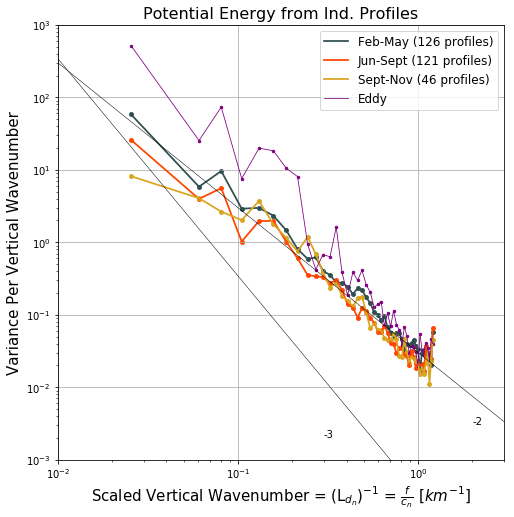

In [144]:
# Potential Energy by season in individual eta profiles 
# make backgrounds now just summer winter
# Summer = June 1 - Sept 15
d_s_i = np.where(((PE_per_prof_time > bd1) & (PE_per_prof_time < bd2)))[0]  # & (Time_ordered < bd2)
# Winter1 = (Feb 2 - June 1)
d_w_i = np.where((PE_per_prof_time < bd1) & ((PE_per_prof_tag < 60) | (PE_per_prof_tag > 71)))[0]
# Winter2 = (Sept 15 - Nov 5)
d_w2_i = np.where((PE_per_prof_time > bd2) 
                  & ((PE_per_prof_tag < 147.5) | (PE_per_prof_tag > 149))
                  & ((PE_per_prof_tag < 157.5) | (PE_per_prof_tag > 158))
                  & ((PE_per_prof_tag < 168) | (PE_per_prof_tag > 170.5)))[0]
# Eddy
d_e_i = np.where((PE_per_prof_tag >= 60) & (PE_per_prof_tag <= 71))[0]
# combine
bckgrds_i = [d_w_i, d_s_i, d_w2_i, d_e_i]  # KEY!! 4, sets of profiles
bckgrds_key = 'Winter', 'Summer', 'Fall', 'Eddy'

matplotlib.rcParams['figure.figsize'] = (8, 8)
f, ax1 = plt.subplots()
labs = 'Feb-May (' + str(np.shape(d_w_i)[0]) + ' profiles)', 'Jun-Sept (' + str(np.shape(d_s_i)[0]) + ' profiles)',\
        'Sept-Nov (' + str(np.shape(d_w2_i)[0]) + ' profiles)', 'Eddy'
# ax1.fill_between(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], sta_min / sta_bats_dk, sta_max / sta_bats_dk,
#                  label='PE$_{sta.}$', color='#D3D3D3')
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds_i)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds_i)))
for i in range(len(bckgrds_i)):
    inn = bckgrds_i[i]
    ax1.plot(sc_x, np.nanmean(PE_per_prof[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(PE_per_prof[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
# modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
# for i in range(len(modeno)):
#     ax1.text(sc_x[i], (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk) + 
#              (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk)/7, modeno[i], color=cols[0])    
# -- GM
# ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * PE_GM_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * PE_GM_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)  
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=15)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=15)
ax1.set_title('Potential Energy from Ind. Profiles', fontsize=16)
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
plot_pro(ax1)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_bats_energy_seasons_w_eddy.jpg", dpi=300)

In [64]:
# print(np.nanmean(PE_per_prof[1, bckgrds_i[0]]/dk))
# print(np.nanmean(PE_per_prof[1, bckgrds_i[1]]/dk))
# print(np.nanmean(PE_per_prof[1, bckgrds_i[2]]/dk))
# profile_tags[eta_ind_3[30, :] > 500]
# PE_per_prof_tag[bckgrds_i[2]]
# # f, ax = plt.subplots()
# # for i in range(len(bckgrds_i[2])):
# #     ax.plot(eta_ind_3[:, profile_tags == PE_per_prof_tag[bckgrds_i[2]][i]], grid)
# # plot_pro(ax) 

# profile_tags[eta_ind_3[30, :] > 500]
np.shape(HKE_per_mass_0)

(46, 131)

In [61]:
savee = 1
if savee > 0:
    my_dict = {'depth': grid, 'KE': avg_KE, 'PE': avg_PE, 'c': c, 'f': f_ref, 'N2_per': N2,
               'PE_all': PE_per_mass_0, 'PE_per_prof_all': PE_per_prof, 'KE_all': HKE_per_mass_0,
               'background_eddy_indicies_for_energy': bckgrds, 'GMPE': GMPE, 'GMKE': GMKE,
               'epsilons_per_season': epsilons, 'season_key': bckgrds_key}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_energy_nov_18_2019.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

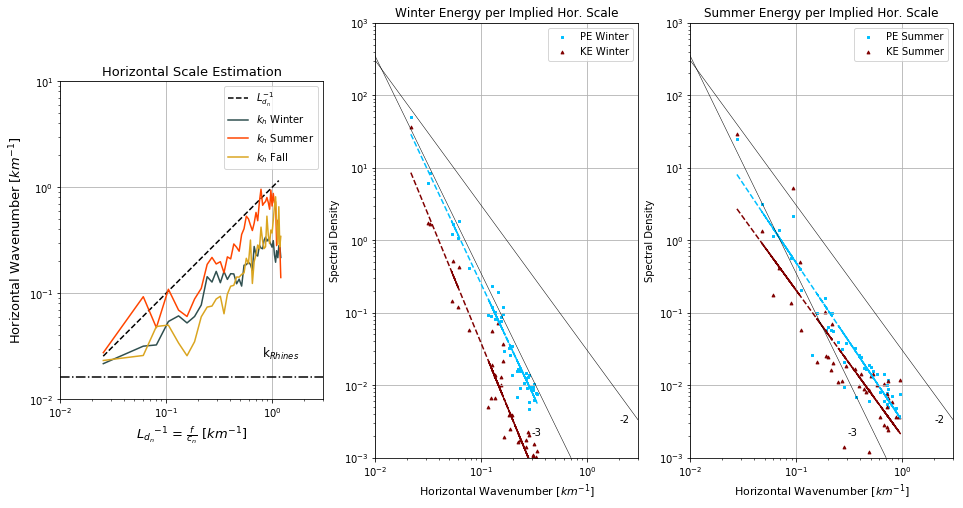

In [25]:
# Rhines Scale 
r_earth = 6371e3  # earth radius [m]
beta_ref = f_ref / (np.tan(np.deg2rad(ref_lat)) * r_earth)
K_beta_2 = 1 / np.sqrt(np.sqrt(np.nanmean(V_ordered**2)) / beta_ref)

matplotlib.rcParams['figure.figsize'] = (16,8)
fig_special, (ax2, ax1, ax3) = plt.subplots(1, 3)

ax2.plot([1000 * f_ref / c[1], 1000 * f_ref / c[-2]], [1000 * f_ref / c[1], 1000 * f_ref / c[-2]], linestyle='--',
            color='k', linewidth=1.5, zorder=2, label=r'$L_{d_n}^{-1}$')
ax2.plot(sc_x, k_h_win1, color=cols[0], label=r'$k_h$ Winter', linewidth=1.5)
ax2.plot(sc_x, k_h_sum, color=cols[1], label=r'$k_h$ Summer', linewidth=1.5)
ax2.plot(sc_x, k_h_win2, color=cols[2], label=r'$k_h$ Fall', linewidth=1.5)
ax2.plot([10**-2, 10**1], 1e3 * np.array([K_beta_2, K_beta_2]), color='k', linestyle='-.')
ax2.text(0.8, 0.025, r'k$_{Rhines}$', fontsize=12)
ax2.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-2), 10 ** 1])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Horizontal Scale Estimation', fontsize=13)
ax2.set_xlabel(r'$L_{d_n}$$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=13)
ax2.set_ylabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=13)
ax2.set_aspect('equal')
ax2.grid()

# energy now as a function of horizontal wavenumber (slope fit too)
fit_max = 42
k_xx_w1 = k_h_win1.copy()
k_xx_s = k_h_sum.copy()
x_3h_w1 = np.log10(k_xx_w1[0:fit_max])
x_3h_s = np.log10(k_xx_s[0:fit_max])
# PE
yy_w1 = np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1) / dk
yy_s = np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1) / dk
y_3p_w1 = np.log10(yy_w1[0:fit_max])
y_3p_s = np.log10(yy_s[0:fit_max])
slope_pe_h_w1 = np.polyfit(x_3h_w1, y_3p_w1, 1)
y_g_pe_h_w1 = np.polyval(slope_pe_h_w1, x_3h_w1)
slope_pe_h_s = np.polyfit(x_3h_s, y_3p_s, 1)
y_g_pe_h_s = np.polyval(slope_pe_h_s, x_3h_s)
# KE
yy2_w1 = np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) / dk
yy2_s = np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) / dk
y_3h_w1 = np.log10(yy2_w1[0:fit_max])
y_3h_s = np.log10(yy2_s[0:fit_max])
slope_ke_h_w1 = np.polyfit(x_3h_w1, y_3h_w1, 1)
y_g_ke_h_w1 = np.polyval(slope_ke_h_w1, x_3h_w1)
slope_ke_h_s = np.polyfit(x_3h_s, y_3h_s, 1)
y_g_ke_h_s = np.polyval(slope_ke_h_s, x_3h_s)

scols = ['#00BFFF', '#6B8E23', '#800000']
# winter
# PE
ax1.scatter(k_h_win1, yy_w1, 8, color=scols[0], marker='s', label='PE Winter')
ax1.plot(10 ** x_3h_w1, 10 ** y_g_pe_h_w1, color=scols[0], linewidth=1.5, linestyle='--')
# KE
ax1.scatter(k_h_win1, yy2_w1, 8, color=scols[2], marker='^', label='KE Winter')
ax1.plot(10 ** x_3h_w1, 10 ** y_g_ke_h_w1, color=scols[2], linewidth=1.5, linestyle='--')
ax1.plot([7 * 10 ** -3, 7 * 10 ** -1], [10 ** 3, 10 ** -3], color='k', linewidth=0.5)
ax1.text(3 * 10 ** -1, 2 * 10 ** -3, '-3', fontsize=10)
ax1.plot([10 ** -2, 10 ** 1], [3 * 10 ** 2, 3 * 10 ** -4], color='k', linewidth=0.5)
ax1.text(2 * 10 ** 0, 3 * 10 ** -3, '-2', fontsize=10)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-3), 1 * 10 ** 3])
ax1.set_xlabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=11)
ax1.set_title('Winter Energy per Implied Hor. Scale')
ax1.set_ylabel('Spectral Density')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid()


# summer
ax3.scatter(k_h_sum, yy_s, 8, color=scols[0], marker='s', label='PE Summer')
ax3.plot(10 ** x_3h_s, 10 ** y_g_pe_h_s, color=scols[0], linewidth=1.5, linestyle='--')
ax3.scatter(k_h_sum, yy2_s, 8, color=scols[2], marker='^', label='KE Summer')
ax3.plot(10 ** x_3h_s, 10 ** y_g_ke_h_s, color=scols[2], linewidth=1.5, linestyle='--')
ax3.plot([7 * 10 ** -3, 7 * 10 ** -1], [10 ** 3, 10 ** -3], color='k', linewidth=0.5)
ax3.text(3 * 10 ** -1, 2 * 10 ** -3, '-3', fontsize=10)
ax3.plot([10 ** -2, 10 ** 1], [3 * 10 ** 2, 3 * 10 ** -4], color='k', linewidth=0.5)
ax3.text(2 * 10 ** 0, 3 * 10 ** -3, '-2', fontsize=10)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax3.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-3), 1 * 10 ** 3])
ax3.set_xlabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=11)
ax3.set_title('Summer Energy per Implied Hor. Scale')
ax3.set_ylabel('Spectral Density')
ax3.set_yscale('log')
ax3.set_xscale('log')
plot_pro(ax3)
fig_special.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_bats_energy_hor_sc.jpg", dpi=300)

In [102]:
# find velocity profiles with speeds in the upper few hundred meters (and eddy profiles)
# look at bottom t/s to see if there is stirring 
print(np.where(np.abs(V2[40, :]) > 0.25)[0])
strong_profs = Info2[np.where(np.abs(V2[40, :]) > 0.25)[0]]
print(strong_profs)

[ 14  15  46  47  49  50  51  52  67  87 102 122 126]
[  73.    73.5   80.5   81.    82.    82.5   83.    83.5  133.    63.5
   22.5  105.   107. ]


In [61]:
rho_1 = 27.5, 27.8, 27.98, 28.05, 28.1275, 28.13, 28.131
# rho_1 = 27.5, 27.8, 27.98, 28.05, 28.12, 28.125, 28.1275, 28.13, 28.11, 28.1275,

In [62]:
dg_raw_f = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg041_2018_raw_t_s_gamma.mat')
dg_data = dg_raw_f['out']
g_raw_36 = dg_data['Neut_den'][0]
t_raw_36 = dg_data['Temp'][0]
s_raw_36 = dg_data['Sal'][0]
p_raw_36 = dg_data['Pressure'][0]
time_raw_36 = dg_data['Time'][0]
lon_raw_36 = dg_data['Lon'][0]
lat_raw_36 = dg_data['Lat'][0]
prof_n_36 = dg_data['prof_number'][0]
SA_grid = dg_data['SA_grid'][0][0]
CT_grid = dg_data['CT_grid'][0][0]
gamma_grid_4 = dg_data['Gamma4'][0][0]

spice_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
ct_per_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
sa_per_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
dep_rec_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
lon_in_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
lat_in_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
time_in_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
for m in range(len(rho_1)):
    for i in range(0, len(prof_n_36)):
        this_z = -1.0 * gsw.z_from_p(p_raw_36[i], np.nanmean(lat_raw_36[i]))
        sa_r = gsw.SA_from_SP(s_raw_36[i], p_raw_36[i], lon_raw_36[i], lat_raw_36[i])
        ct_r = gsw.CT_from_t(s_raw_36[i], t_raw_36[i], p_raw_36[i])
        z_on = np.interp(rho_1[m], np.squeeze(g_raw_36[i]), np.squeeze(this_z))
        
        dep_rec_36[i, m] = z_on
        sa_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(sa_r))
        ct_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(ct_r))
        lon_in_36[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lon_raw_36[i]))
        lat_in_36[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lat_raw_36[i]))
        time_in_36[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(time_raw_36[i]))
        spice_36[i, m] = gsw.spiciness1(sa_in, ct_in)
        ct_per_36[i, m] = ct_in
        sa_per_36[i, m] = sa_in
ref_lon_36 = np.nanmean(lon_in_36)        
ref_lat_36 = np.nanmean(lat_in_36) 

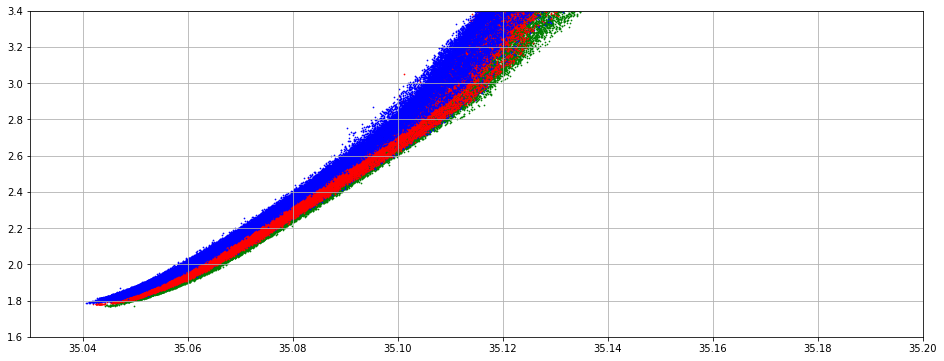

()

In [63]:
f, ax = plt.subplots()
for i in range(20, len(prof_n_36)):
    sa_r = gsw.SA_from_SP(s_raw_36[i], p_raw_36[i], lon_raw_36[i], lat_raw_36[i])
    ct_r = gsw.CT_from_t(s_raw_36[i], t_raw_36[i], p_raw_36[i])
    if prof_n_36[i] < 90:
        ax.scatter(sa_r, ct_r, s=0.5, color='g')
    elif (prof_n_36[i] > 90) & (prof_n_36[i] < 130):
        ax.scatter(sa_r, ct_r, s=0.5, color='r')    
    else:
        ax.scatter(sa_r, ct_r, s=0.5, color='b')
ax.set_xlim([35.03, 35.2])    
ax.set_ylim([1.6, 3.4])
plot_pro(ax)

In [64]:
# raw T/S/Gamma/Spice from 35 
dg_raw_f = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg035_2015_raw_t_s_gamma.mat')
dg_data = dg_raw_f['out']
g_raw = dg_data['Neut_den'][0]
t_raw = dg_data['Temp'][0]
s_raw = dg_data['Sal'][0]
p_raw = dg_data['Pressure'][0]
time_raw = dg_data['Time'][0]
lon_raw = dg_data['Lon'][0]
lat_raw = dg_data['Lat'][0]
prof_n = dg_data['prof_number'][0]
SA_grid = dg_data['SA_grid'][0][0]
CT_grid = dg_data['CT_grid'][0][0]
gamma_grid_4 = dg_data['Gamma4'][0][0]

spice = np.nan * np.ones((len(prof_n), len(rho_1)))
ct_per = np.nan * np.ones((len(prof_n), len(rho_1)))
sa_per = np.nan * np.ones((len(prof_n), len(rho_1)))
dep_rec = np.nan * np.ones((len(prof_n), len(rho_1)))
lon_in = np.nan * np.ones((len(prof_n), len(rho_1)))
lat_in = np.nan * np.ones((len(prof_n), len(rho_1)))
time_in = np.nan * np.ones((len(prof_n), len(rho_1)))
for m in range(len(rho_1)):
    for i in range(20, len(prof_n)):
        this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
        sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
        ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
        z_on = np.interp(rho_1[m], np.squeeze(g_raw[i]), np.squeeze(this_z))  # depth of isopycnal 
        
        dep_rec[i, m] = z_on
        sa_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(sa_r))  # interpolate salinity at that depth 
        ct_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(ct_r))
        lon_in[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lon_raw[i]))
        lat_in[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lat_raw[i]))
        time_in[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(time_raw[i]))
        spice[i, m] = gsw.spiciness1(sa_in, ct_in)
        ct_per[i, m] = ct_in
        sa_per[i, m] = sa_in
ref_lon = np.nanmean(lon_in)        
ref_lat = np.nanmean(lat_in) 
np.nanstd(spice[:, 5])

0.0013509495949315597

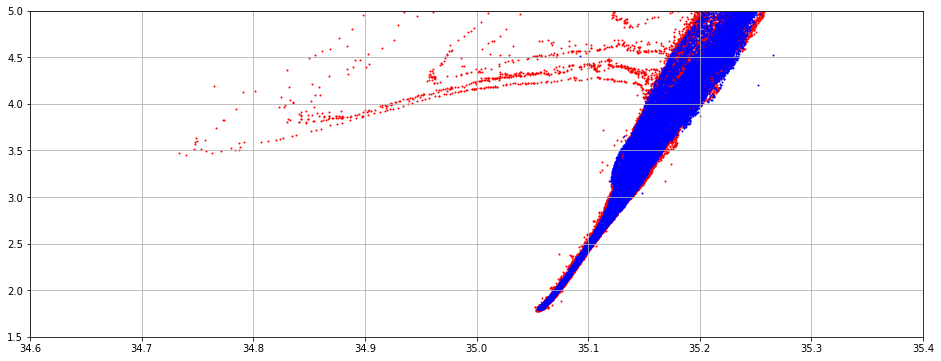

()

In [65]:
f, ax = plt.subplots()
for i in range(20, len(prof_n)):
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    if prof_n[i] < 100:
        ax.scatter(sa_r, ct_r, s=1, color='r')
    else:
        ax.scatter(sa_r, ct_r, s=1, color='b')
ax.set_xlim([34.6, 35.4])    
ax.set_ylim([1.5, 5])
plot_pro(ax)

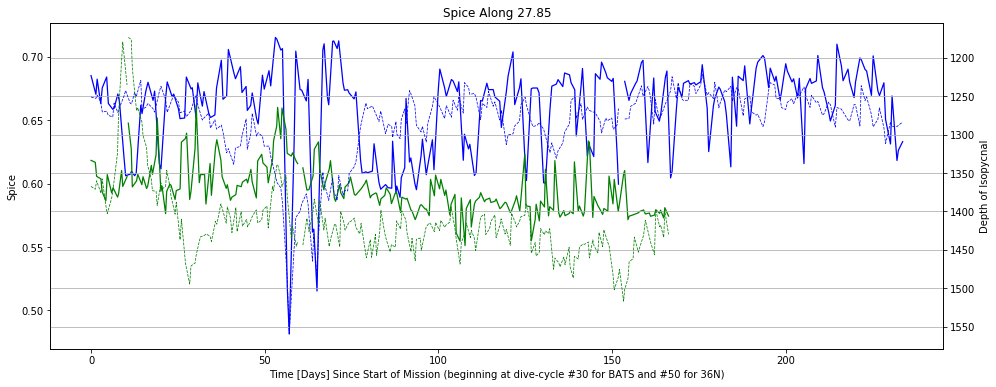

In [189]:
# time series of spice on an isopycnal
thisi_i = [5]
f, ax = plt.subplots()
ax2 = ax.twinx()
for thisi in thisi_i:
    t_grid = np.arange(0, 150, 1)
    t_lags = np.arange(1, 30, 1)
    # bats 
    this_t = time_in[:, thisi] - time_in[20, thisi]
    this_ct = ct_per[:, thisi]
    this_sp = spice[:, thisi]
    this_dep = dep_rec[:, thisi]
    ct_grid = np.interp(t_grid, this_t, this_ct)
    sp_grid = np.interp(t_grid, this_t, this_sp)
    dep_grid = np.interp(t_grid, this_t, this_dep)

    # 36n
    this_t_36 = time_in_36[:, thisi] - time_in_36[0, thisi]
    this_ct_36 = ct_per_36[:, thisi]
    this_sp_36 = spice_36[:, thisi]
    this_dep_36 = dep_rec_36[:, thisi]
    ct_grid_36 = np.interp(t_grid, this_t_36, this_ct_36)
    sp_grid_36 = np.interp(t_grid, this_t_36, this_sp_36)
    dep_grid_36 = np.interp(t_grid, this_t_36, this_dep_36)

    ax.plot(this_t, this_sp, label='BATS 2015', color='b', linewidth=1.25)
    # ax.plot(t_grid, sp_grid, color='r', linestyle='--')
    ax2.plot(this_t, this_dep, color='b', linewidth=0.75, linestyle='--')
    ax.plot(this_t_36, this_sp_36, 'g', label='36N 2018', linewidth=1.25)
    # ax.plot(t_grid, sp_grid_36, color='y', linestyle='--')
    ax2.plot(this_t_36, this_dep_36, color='g', linewidth=0.75, linestyle='--')
    ax.set_title('Spice Along ' + str(rho_1[thisi]))
    ax.set_ylabel('Spice')
    ax.set_xlabel('Time [Days] Since Start of Mission (beginning at dive-cycle #30 for BATS and #50 for 36N)')
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, fontsize=11)
    # ax.set_ylim([0.14, 0.171])
    # ax2.set_ylim([3100, 4000])
    # ax.set_ylim([0.5, 0.75])
    # ax2.set_ylim([1100, 1600])
    # ax.set_ylim([np.nanmax(this_sp)+.05, np.nanmax(this_sp)+.05])
    # ax2.set_ylim([900, 1400])
ax2.set_ylabel('Depth of Isopycnal')
ax2.invert_yaxis()
plot_pro(ax2)

# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_36n_spice_comp_4.jpg", dpi=300)

# acf = np.nan*np.ones(len(t_lags))
# for m in range(len(t_lags)):
#     ct_i = np.nan * np.ones(len(ct_grid) - t_lags[m])
#     for i in range(len(ct_grid) - t_lags[m]):
#         ct_i[i] = (ct_grid[i] - np.nanmean(ct_grid)) * (ct_grid[i+t_lags[m]] - np.nanmean(ct_grid))
#     acf[m] = (1/(len(ct_grid) - t_lags[m])) * np.nansum(ct_i)   

# f, ax = plt.subplots()
# ax.plot(t_lags, acf/(np.nanstd(ct_grid)**2))
# plot_pro(ax)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in less
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: Mean of empty slice


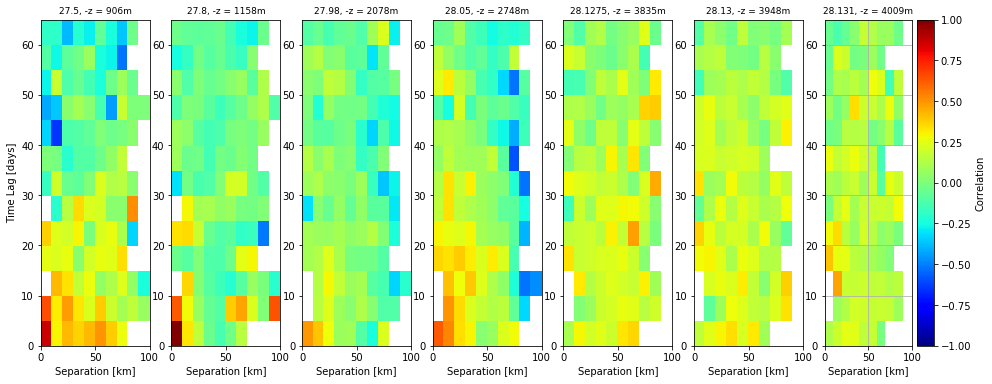

()

In [66]:
# ---  T/S variability (and correlations) on isopycnals --- 
# ---------------------------
# Mode Amplitude Correlations 
matplotlib.rcParams['figure.figsize'] = (16,6)    
dist_t_win = np.arange(0, 105, 10)
t_t_win = np.arange(0, 70, 5)
avg_cor = np.nan * np.ones((len(t_t_win), len(rho_1)))
f, ax = plt.subplots(1, len(rho_1))
this_ref_lon = ref_lon
this_ref_lat = ref_lat
for l in range(len(rho_1)):
    this_lon_in = lon_in
    this_lat_in = lat_in
    this_time_in = time_in
    this_spice = spice
    
    x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (this_lon_in[:, l] - this_ref_lon) / 1000
    y = 1852 * 60 * (this_lat_in[:, l] - this_ref_lat) / 1000
    
    n = len(this_spice[:, l]) - np.sum(np.isnan(this_spice[:, l]))
    sp_mean = np.nanmean(this_spice[:, l])
    sp_var = np.nanvar(this_spice[:, l])
    t_range = np.nanmax(this_time_in[:, l]) - np.nanmin(this_time_in[:, l])
    t = this_time_in[:, l]
#     time_tile = np.tile(t, (len(t), 1))
#     dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
#     time_lag = np.abs(time_tile - time_tile.T)

    # distances apart
    for i in range(len(x) - 1):
        if i < 1:
            dist_x = x[i+1:] - x[i]
            dist_y = y[i+1:] - y[i]
            dist_t = np.sqrt(dist_x**2 + dist_y**2)
            time_l = np.abs(t[i] - t[i+1:])
            # pairs of spice values that correspond to list of time lags and spatial separation 
            spice_count = np.array((this_spice[i, l] * np.ones(len(x[i+1:])), this_spice[i+1:, l]))
            # each observation is used in many pairs 
        else:
            dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
            dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
            dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i+1:] - y[i])**2)))
            time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
            spice_count = np.concatenate((spice_count, 
                                          np.array((this_spice[i, l] * np.ones(len(x[i + 1:])), this_spice[i + 1:, l]))), axis=1)
        
    # define each box as all points that fall within a time and space lag
    corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))

    # spatial separation             
    for dd in range(len(dist_t_win) - 1):
        for tt in range(len(t_t_win) - 1):
            in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                                (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
            if len(in_box) > 25:
                # pairs that fall in each box 
                inski_with = spice_count[:, in_box]                   
                inski, inski_i = np.unique(spice_count[:, in_box], return_index=True)
                i_mean = np.nanmean(inski)
                n = len(inski_with[0, :]) # number of pairs
                variance = np.nanvar(inski)
                covi = (inski_with[0, :] - i_mean) * (inski_with[1, :] - i_mean)
                corr_i_all[tt, dd] = (1 / ((n) * variance)) * np.nansum(covi)   
                # (n - t_t_win[tt]/.8)
                
    avg_cor[:, l] = np.nanmean(corr_i_all[:, 2:15], axis=1)
    corr_i_all[np.isnan(corr_i_all)] = -999
    cmap = plt.cm.jet
    pa = ax[l].pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap=cmap)
    cmap.set_under('w')
    ax[l].set_xlabel('Separation [km]')
    ax[l].set_title(str(rho_1[l]) + ', -z = ' + str(np.int(np.nanmean(dep_rec[:, l]))) + 'm', fontsize=9)
plt.colorbar(pa, label='Correlation')
ax[0].set_ylabel('Time Lag [days]')
plot_pro(ax[l])  
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_spice_corr.jpg", dpi=300)

1.3478198848810038e-05

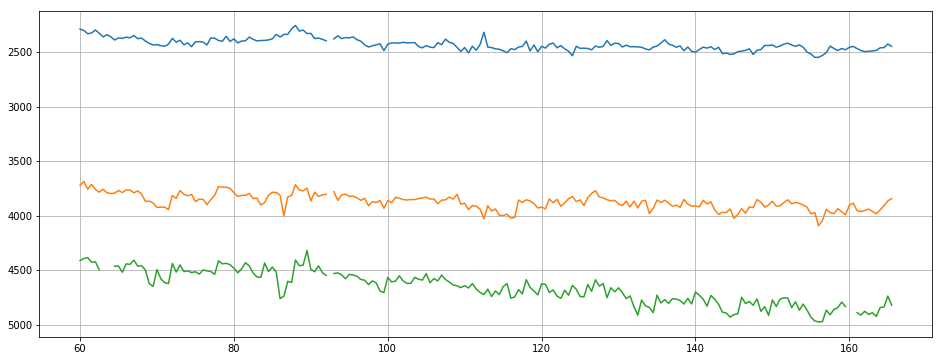

()

In [117]:
f, ax = plt.subplots()
# ax.plot(np.arange(20, 20 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 0])
ax.plot(np.arange(50, 50 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 3])
ax.plot(np.arange(50, 50 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 5])
ax.plot(np.arange(50, 50 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 6])
ax.invert_yaxis()
plot_pro(ax)

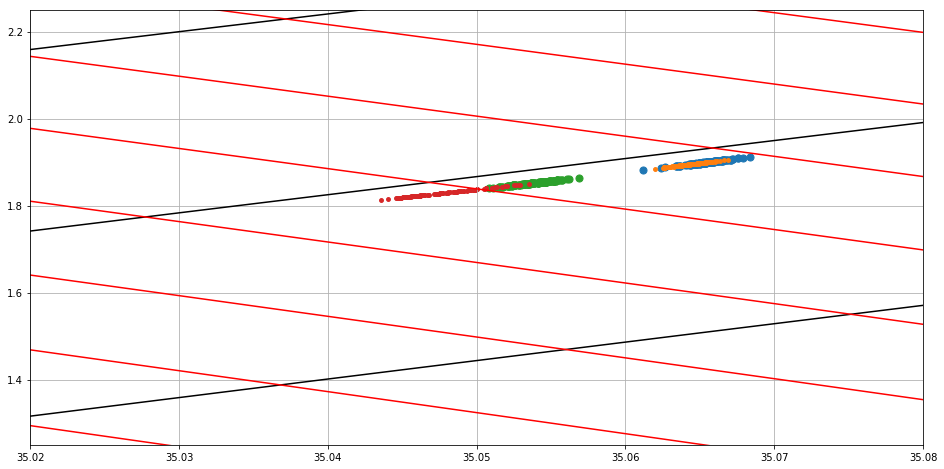

()

In [261]:
SP_grid = gsw.spiciness2(SA_grid, CT_grid)
f, ax = plt.subplots()
gg = ax.contour(SA_grid, CT_grid, gamma_grid_4, colors='k', levels=np.arange(27, 28.5, 0.05))
ax.clabel(gg, inline_spacing=-3, fmt='%1.0f', colors='k')
spg = ax.contour(SA_grid, CT_grid, SP_grid, colors='r', levels=np.arange(0, 1, 0.025))
ax.clabel(spg)

ini = 4
ax.scatter(sa_per[0:150, ini], ct_per[0:150, ini], s=50)
ax.scatter(sa_per[150:, ini], ct_per[150:, ini], s=15)
ax.scatter(sa_per_36[0:115, ini], ct_per_36[0:115, ini], s=50)
ax.scatter(sa_per_36[115:, ini], ct_per_36[115:, ini], s=15)
ax.set_xlim([35.02, 35.08])
ax.set_ylim([1.25, 2.25])
plot_pro(ax)

In [254]:
ct_per[0:150, ini]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        2.74991042,  2.74028151,  2.75048162,  2.7286037 ,  2.71292768,
        2.70036157,  2.69927261,  2.71399419,  2.71343197,  2.70521678,
        2.72060226,  2.72230446,  2.71871632,  2.71406469,  2.71877249,
        2.70603421,  2.71231942,  2.71501499,  2.73613547,  2.73118263,
        2.72670954,  2.70952745,  2.70639373,  2.70359053,  2.71754954,
        2.7166591 ,  2.71921045,  2.72068495,  2.73418535,  2.7209978 ,
        2.71496682,  2.71065907,  2.71398487,  2.71265889,  2.71978253,
        2.70915197,  2.72997954,  2.73229706,  2.71718066,  2.70933732,
        2.73217787,  2.73577423,  2.73175954,  2.72773269,  2.71997822,
        2.70454657,  2.72206901,  2.72871622,  2.70911898,  2.72

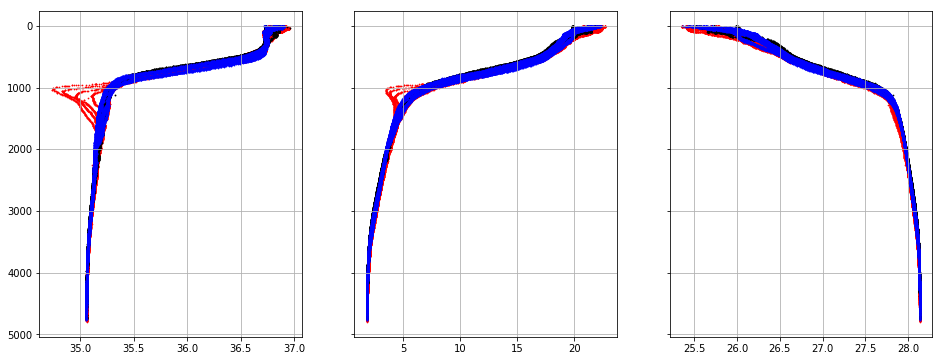

()

In [140]:
# bats 2015
e_pre = np.where((prof_n >= 45) & (prof_n <= 55))[0]
e_in = np.where((prof_n > 57) & (prof_n < 70))[0]
e_po = np.where((prof_n >= 70) & (prof_n <= 80))[0]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
for i in e_in:
    this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    
    if np.nanmax(this_z) > 4400:
        ax1.scatter(sa_r, this_z, s=0.5, color='r')
        ax2.scatter(ct_r, this_z, s=0.5, color='r')
        ax3.scatter(g_raw[i], this_z, s=0.5, color='r')
#     ax1.scatter(s_raw[i], this_z, s=0.5)
#     ax2.scatter(t_raw[i], this_z, s=0.5)
for i in e_pre:
    this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    
    if np.nanmax(this_z) > 4400:
        ax1.scatter(sa_r, this_z, s=0.75, color='k')
        ax2.scatter(ct_r, this_z, s=0.75, color='k')
        ax3.scatter(g_raw[i], this_z, s=0.5, color='k')
#     ax1.scatter(s_raw[i], this_z, s=0.75, color='k')
#     ax2.scatter(t_raw[i], this_z, s=0.75, color='k')  
for i in e_po:
    this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    
    if np.nanmax(this_z) > 4400:
        ax1.scatter(sa_r, this_z, s=0.75, color='b')
        ax2.scatter(ct_r, this_z, s=0.75, color='b')
        ax3.scatter(g_raw[i], this_z, s=0.5, color='b')
#     ax1.scatter(s_raw[i], this_z, s=0.75, color='k')
#     ax2.scatter(t_raw[i], this_z, s=0.75, color='k')   
    
# ax1.set_ylim([4200, 4820])   
# ax1.set_xlim([35.04, 35.075])
# ax2.set_xlim([1.75, 2])
ax1.invert_yaxis()
ax1.grid()
ax2.grid()
plot_pro(ax3)

### prof_n

In [ ]:
# take sample transect and compute potential vorticity 
this_transect = 25  # 35 = eddy 
dace_mw_i = DACe_MW[this_transect][0:-1]
dacn_mw_i = DACn_MW[this_transect][0:-1]
dg_v_i = v_g[this_transect][:, 0:-1]
dg_v_e_i = v_g_east[this_transect][:, 0:-1]
dg_v_n_i = v_g_north[this_transect][:, 0:-1]
avg_sig0_per_dep_i = avg_sig0_per_dep_0[this_transect]
avg_ct_per_dep_i = avg_ct_per_dep_0[this_transect]
avg_sa_per_dep_i = avg_sa_per_dep_0[this_transect]
dg_v_lon_i = mwe_lon[this_transect][0:-1]
dg_v_lat_i = mwe_lat[this_transect][0:-1]
dg_v_dive_no_i = profile_tags_per[this_transect][0:-1]

# extract individual profiles of this transect 
p_in_0 = np.where((profile_tags >= dg_v_dive_no_i.min()) & (profile_tags <= dg_v_dive_no_i.max()))[0]
p_in = np.append(p_in_0, p_in_0[-1] + 1)
lon_p_i = lon[:, p_in]
lat_p_i = lat[:, p_in]

ref_lat_i = np.nanmean(lat_p_i[0, 0])
ref_lon_i = np.nanmean(lon_p_i[0, 0])
tsx = 1852 * 60 * np.cos(np.deg2rad(ref_lat_i)) * (lon_p_i - ref_lon_i)
tsy = 1852 * 60 * (lat_p_i - ref_lat_i)
tsd = np.sqrt(tsx**2 + tsy**2)
grid_i = np.transpose(np.tile(grid, (len(p_in), 1)))

vsx = 1852 * 60 * np.cos(np.deg2rad(ref_lat_i)) * (dg_v_lon_i - ref_lon_i)
vsy = 1852 * 60 * (dg_v_lat_i - ref_lat_i)
vsd = np.sqrt(vsx**2 + vsy**2)

b_i = g * (1 - (1000 + avg_sig0_per_dep_i)/1027)  

dv_dz_i = np.nan * np.ones(np.shape(dg_v_i))
for i in range(len(vsx)):
    dv_dz_i[:, i] = np.gradient(dg_v_i[:, i], -1 * grid)
dv_dx_i = np.nan * np.ones(np.shape(dg_v_i))
db_dx_i = np.nan * np.ones(np.shape(dg_v_i))
for i in range(len(grid)):
    dv_dx_i[i, 1:-1] = np.gradient(dg_v_i[i, 1:-1], vsd[1:-1])
    db_dx_i[i, 1:-1] = np.gradient(b_i[i, 1:-1], vsd[1:-1])

q_i = (dv_dx_i + f_ref) * np.transpose(np.tile(N2[:, 0], (len(vsd), 1))) - (db_dx_i * dv_dz_i)
# q_i[q_i < -1*10**(25)] = np.nan
# q_i[q_i > 1*10**(25)] = np.nan
q_i = q_i / (10**(-10))

matplotlib.rcParams['figure.figsize'] = (12,8)
f, ax = plt.subplots()
ax.contourf(vsd, grid, q_i, levels=np.arange(0, 100, 0.5))  # q_i, vmin = 0, vmax = 1)
ax.contour(vsd, grid, q_i, levels=np.arange(0, 50, 5), colors='w')  # q_i, vmin = 0, vmax = 1)
# ax.contour(vsd, grid, q_i, levels=np.arange(0, 20, 4), colors='g')  # q_i, vmin = 0, vmax = 1)
ax.contour(vsd, grid, dg_v_i, levels=np.arange(-.3, .3, 0.025), colors='r')  # q_i, vmin = 0, vmax = 1)
ax.scatter(tsd, grid_i, s=1)
ax.set_ylim([0, 2000])
ax.invert_yaxis()
plot_pro(ax)

In [ ]:
# --- Calculation of dynamic height and comparison to satellite data 
p_ref = 4000
eddy_i = np.where((profile_tags > 59) & (profile_tags < 69))[0]
pre_eddy_i = np.where((profile_tags > 69) & (profile_tags < 79))[0]
surf_dyn_height = np.nan * np.ones(len(eddy_i))
pre_surf_dyn_height = np.nan * np.ones(len(pre_eddy_i))
# computation of dynamic height relative to bottom pressure 
# eddy profiles 
for i in range(len(eddy_i)):
    lb = np.where(np.isnan(sa[400:, eddy_i[i]]))[0]
    if len(lb) > 0:
        p_ref = grid_p[400 + lb[0] - 1]
    else:
        p_ref = grid_p[-1]
    print(p_ref)    
    res = gsw.geo_strf_dyn_height(sa[:, eddy_i[i]], ct[:, eddy_i[i]], grid_p, p_ref)
    if np.sum(np.isnan(res)) < 10:
        surf_dyn_height[i] = res[~np.isnan(res)][0] / g
# pre eddy profiles        
for i in range(len(pre_eddy_i)):    
    lb = np.where(np.isnan(sa[100:, pre_eddy_i[i]]))[0]
    if len(lb) > 0:
        p_ref = grid_p[100 + lb[0] - 1]
    else:
        p_ref = grid_p[-1]
    pre_res = gsw.geo_strf_dyn_height(sa[:, pre_eddy_i[i]], ct[:, pre_eddy_i[i]], grid_p, p_ref)
    if np.sum(np.isnan(pre_res)) < 10:
        pre_surf_dyn_height[i] = pre_res[~np.isnan(pre_res)][0] / g

B15 = Dataset('/Users/jake/Documents/baroclinic_modes/Altimetry/AVISO/dataset-duacs-rep-global-merged-allsat-phy-l4_n_atl_2015.nc', 'r')
lat15 = B15.variables['latitude'][:]
lon15 = B15.variables['longitude'][:] - 360;
adt15 = B15.variables['adt'][:][120, :, :]
sla15 = B15.variables['sla'][:][120, :, :]
        
# plotting 
cmin = 3.1  # np.nanmin(surf_dyn_height)
cmax = 3.4  # np.nanmax(surf_dyn_height)
jj = plt.get_cmap('jet')
    
matplotlib.rcParams['figure.figsize'] = (14,6)    
f, (ax1, ax2) = plt.subplots(1, 2)
for i in range(len(pre_eddy_i)):
    ax1.contour(lon15[:], lat15[:], sla15, levels=np.arange(-1.0, 1.0, 0.05))
    ax1.scatter(np.nanmean(prof_lon[:, pre_eddy_i[i]], axis=0), np.nanmean(prof_lat[:, pre_eddy_i[i]], axis=0), 
               s=20, color=jj((pre_surf_dyn_height[i] - cmin)/(cmax - cmin)))
    ax1.text(np.nanmean(prof_lon[:, pre_eddy_i[i]], axis=0) + 0.02, np.nanmean(prof_lat[:, pre_eddy_i[i]], axis=0), 
            profile_tags[pre_eddy_i[i]])
for i in range(len(eddy_i)):    
    ax2.scatter(np.nanmean(prof_lon[:, eddy_i[i]], axis=0), np.nanmean(prof_lat[:, eddy_i[i]], axis=0), 
               s=20, color=jj((surf_dyn_height[i] - cmin)/(cmax - cmin)))
    ax2.text(np.nanmean(prof_lon[:, eddy_i[i]], axis=0) + 0.02, np.nanmean(prof_lat[:, eddy_i[i]], axis=0), 
            profile_tags[eddy_i[i]])
    # print((surf_dyn_height[i] - cmin)/(cmax - cmin))
ax1.set_xlim([-65, -63])
ax1.set_ylim([31, 33])
ax1.grid()
plot_pro(ax2)